In [1]:
# !pip install tqdm
# !pip install transformers
# !pip install seaborn
# !pip install scipy
# !pip install pandas

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer
import networkx as nx
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_random_seed(seed: int) -> None:
    """Sets the random seed for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
set_random_seed(42)

In [5]:
import torch
torch.__version__

'2.6.0+cu124'

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
class PoincareManifold:
    """Implementation of the Poincaré ball model of hyperbolic space."""
    
    def __init__(self, dim, curvature=-1.0):
        """
        Initialize the Poincaré ball model.
        
        Args:
            dim: Dimensionality of the space
            curvature: Curvature parameter (default: -1.0)
        """
        self.dim = dim
        self.curvature = curvature
        self.eps = 1e-15
    
    def _check_point_on_manifold(self, x):
        """Check if point is on the manifold (i.e., inside the Poincaré ball)."""
        norm = torch.sum(x * x, dim=-1)
        if torch.any(norm >= 1.0):
            print(f"Warning: Points with norm >= 1.0 detected: {norm[norm >= 1.0]}")
        return torch.all(norm < 1.0)
    
    def _mobius_addition(self, x, y):
        """
        Möbius addition in the Poincaré ball.
        
        Args:
            x, y: Points in the Poincaré ball
            
        Returns:
            Möbius addition x ⊕ y
        """
        # Compute squared norms
        x_norm_sq = torch.sum(x * x, dim=-1, keepdim=True)
        y_norm_sq = torch.sum(y * y, dim=-1, keepdim=True)
        
        # Compute dot product
        xy_dot = torch.sum(x * y, dim=-1, keepdim=True)
        
        # Compute denominator
        denom = 1 + 2 * xy_dot + y_norm_sq * x_norm_sq
        
        # Compute numerator
        numer_1 = (1 + 2 * xy_dot + y_norm_sq) * x
        numer_2 = (1 - x_norm_sq) * y
        
        return (numer_1 + numer_2) / denom
    
    def _mobius_scalar_mul(self, r, x):
        """
        Möbius scalar multiplication in the Poincaré ball.
        
        Args:
            r: Scalar
            x: Point in the Poincaré ball
            
        Returns:
            Möbius scalar multiplication r ⊗ x
        """
        x_norm = torch.norm(x, dim=-1, keepdim=True)
        
        # Handle zero-norm case
        if torch.any(x_norm == 0):
            return x
        
        # Compute factor
        factor = torch.tanh(r * torch.atanh(x_norm)) / x_norm
        
        return factor * x
    
    def distance(self, x, y):
        """
        Compute the hyperbolic distance between points in the Poincaré ball.
        
        Args:
            x, y: Points in the Poincaré ball
            
        Returns:
            Hyperbolic distance between x and y
        """
        # Ensure points are on the manifold
        self._check_point_on_manifold(x)
        self._check_point_on_manifold(y)
        
        # Compute squared norm of difference using Möbius addition and negation
        neg_y = -y
        z = self._mobius_addition(x, neg_y)
        z_norm_sq = torch.sum(z * z, dim=-1)
        
        # Compute distance using the formula
        # d_H(x, y) = 2 * atanh(||−y ⊕ x||)
        return 2 * torch.atanh(torch.sqrt(z_norm_sq.clamp(min=self.eps, max=1-self.eps)))
    
    def expmap0(self, v):
        """
        Exponential map from the tangent space at the origin to the Poincaré ball.
        
        Args:
            v: Tangent vector at the origin
            
        Returns:
            Point on the Poincaré ball
        """
        v_norm = torch.norm(v, dim=-1, keepdim=True)
        
        # Handle zero-norm case
        zeros = torch.zeros_like(v_norm)
        v_norm = torch.where(v_norm == 0, zeros + self.eps, v_norm)
        
        # Compute scaling factor
        factor = torch.tanh(v_norm) / v_norm
        
        return factor * v
    
    def logmap0(self, x):
        """
        Logarithmic map from the Poincaré ball to the tangent space at the origin.
        
        Args:
            x: Point on the Poincaré ball
            
        Returns:
            Tangent vector at the origin
        """
        # Ensure point is on the manifold
        self._check_point_on_manifold(x)
        
        x_norm = torch.norm(x, dim=-1, keepdim=True)
        
        # Handle zero-norm case
        zeros = torch.zeros_like(x_norm)
        x_norm = torch.where(x_norm == 0, zeros + self.eps, x_norm)
        
        # Compute scaling factor
        factor = torch.atanh(x_norm) / x_norm
        
        return factor * x
    
    def euclidean_to_poincare(self, x):
        """
        Map Euclidean vectors to the Poincaré ball.
        
        Args:
            x: Euclidean vectors
            
        Returns:
            Points on the Poincaré ball
        """
        # Scale to ensure points are inside the ball
        max_norm = torch.max(torch.norm(x, dim=-1))
        if max_norm >= 0.999:
            x = x / (max_norm + 0.001)
        
        return self.expmap0(x)
    
    def poincare_to_euclidean(self, x):
        """
        Map points from the Poincaré ball to Euclidean space.
        
        Args:
            x: Points on the Poincaré ball
            
        Returns:
            Euclidean vectors
        """
        return self.logmap0(x)

In [8]:
def compute_delta_hyperbolicity(distances):
    """
    Compute δ-hyperbolicity of a metric space using Gromov's four-point condition.
    
    Args:
        distances: Pairwise distance matrix
        
    Returns:
        δ-hyperbolicity value
    """
    n = distances.shape[0]
    max_delta = 0.0
    
    # Sample points if the space is too large
    if n > 30:
        indices = np.random.choice(n, 30, replace=False)
        distances = distances[indices][:, indices]
        n = 30
    
    # Iterate through all 4-tuples of points
    for i in range(n):
        for j in range(i+1, n):
            for k in range(j+1, n):
                for l in range(k+1, n):
                    d_ij = distances[i, j]
                    d_kl = distances[k, l]
                    d_ik = distances[i, k]
                    d_jl = distances[j, l]
                    d_il = distances[i, l]
                    d_jk = distances[j, k]
                    
                    # Sort the three sums
                    sums = sorted([d_ij + d_kl, d_ik + d_jl, d_il + d_jk])
                    # Delta is half the difference between the largest two sums
                    delta = (sums[2] - sums[1]) / 2
                    max_delta = max(max_delta, delta)
    
    return max_delta

In [9]:
def estimate_curvature(embeddings):
    """
    Estimate the curvature of the space that best fits the embeddings.
    
    Args:
        embeddings: Embeddings of shape (n, dim)
        
    Returns:
        Estimated curvature value
    """
    # Simple method: try different curvatures and find the best fit
    curvatures = [-0.1, -0.5, -1.0, -2.0, -5.0]
    distortions = []
    
    n = len(embeddings)
    
    # Compute Euclidean distances
    euclidean_distances = torch.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            euclidean_distances[i, j] = torch.norm(embeddings[i] - embeddings[j])
            euclidean_distances[j, i] = euclidean_distances[i, j]
    
    # Try different curvatures
    for c in curvatures:
        manifold = PoincareManifold(dim=embeddings.shape[1], curvature=c)
        poincare_emb = manifold.euclidean_to_poincare(embeddings)
        
        # Compute hyperbolic distances
        hyperbolic_distances = torch.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                hyperbolic_distances[i, j] = manifold.distance(
                    poincare_emb[i].unsqueeze(0),
                    poincare_emb[j].unsqueeze(0)
                )
                hyperbolic_distances[j, i] = hyperbolic_distances[i, j]
        
        # Compute distortion as correlation between distance distributions
        indices = torch.triu_indices(n, n, 1)
        euclidean_flat = euclidean_distances[indices[0], indices[1]]
        hyperbolic_flat = hyperbolic_distances[indices[0], indices[1]]
        
        # Normalize distances
        euclidean_flat = euclidean_flat / euclidean_flat.max()
        hyperbolic_flat = hyperbolic_flat / hyperbolic_flat.max()
        
        # Compute distortion as L2 norm of differences
        distortion = torch.norm(euclidean_flat - hyperbolic_flat)
        distortions.append(distortion.item())
    
    # Return the curvature with minimum distortion
    return curvatures[np.argmin(distortions)]

In [10]:
def compute_tree_likeness(embeddings, manifold):
    """
    Compute a measure of how tree-like a set of embeddings is in hyperbolic space.
    Higher values indicate more tree-like structure.
    
    Args:
        embeddings: Embeddings in the Poincaré ball
        manifold: PoincareManifold object
        
    Returns:
        Tree-likeness score
    """
    # Compute pairwise distances
    n = len(embeddings)
    distances = torch.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            distances[i, j] = manifold.distance(
                embeddings[i].unsqueeze(0),
                embeddings[j].unsqueeze(0)
            )
            distances[j, i] = distances[i, j]
    
    # Compute δ-hyperbolicity
    delta = compute_delta_hyperbolicity(distances)
    
    # Smaller delta means more tree-like, so return inverse
    return 1.0 / (delta + 1e-5)

LOADING IN BERT

In [11]:
def load_bert_model(model_name="bert-base-uncased"):
    """
    Load pre-trained BERT model and tokenizer.
    
    Args:
        model_name: Name of the BERT model
        
    Returns:
        model, tokenizer: BERT model and tokenizer
    """
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name, output_hidden_states=True)
    model.to(device)
    model.eval()
    return model, tokenizer

In [12]:
# !pip install "huggingface_hub[hf_xet]"

In [13]:
def extract_bert_embeddings(model, tokenizer, sentences, layer_indices=None):
    model.eval()
    num_layers = model.config.num_hidden_layers + 1  # +1 for embedding layer
    if layer_indices is None:
        layer_indices = list(range(num_layers))

    batch_size = 8
    all_embeddings = {layer_idx: [] for layer_idx in layer_indices}

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # tuple: (13, batch, seq_len, hidden_dim)

            attention_masks_batch = inputs['attention_mask'].cpu()
            attention_masks_list = []
            
            for layer_idx in layer_indices:
                layer_output = hidden_states[layer_idx].cpu()
                # Slice per sentence, preserving shape
                for j in range(layer_output.shape[0]):
                    all_embeddings[layer_idx].append(layer_output[j])
                    attention_masks_list.append(attention_masks_batch[j])

    # now each layer has a list of (seq_len, hidden_dim) tensors, one per sentence
    for layer_idx in layer_indices:
        all_embeddings[layer_idx] = all_embeddings[layer_idx]

    return all_embeddings, attention_masks_list

In [14]:
def extract_token_embeddings(all_embeddings, attention_masks, remove_special_tokens=True):
    """
    Extract embeddings for individual tokens, optionally removing special tokens.
    
    Args:
        all_embeddings: Dictionary mapping layer indices to embeddings
        attention_masks: Attention masks from tokenizer
        remove_special_tokens: Whether to remove special tokens ([CLS], [SEP], etc.)
        
    Returns:
        dict: Dictionary mapping layer indices to lists of token embeddings
    """
    token_embeddings = {}
    
    for layer_idx, layer_embeddings in all_embeddings.items():
        batch_token_embeddings = []
        
        for i in range(len(layer_embeddings)):
            # Get embeddings for this sentence
            embeddings = layer_embeddings[i]
            mask = attention_masks[i]
            
            # Get indices of real tokens (excluding special tokens if requested)
            if remove_special_tokens:
                # The first token is [CLS], so exclude it
                start_idx = 1
                # Find the position of [SEP] and exclude it too
                sep_pos = mask.sum().item() - 1
                indices = list(range(start_idx, sep_pos))
            else:
                # Include all tokens with attention mask == 1
                indices = [j for j in range(len(mask)) if mask[j] == 1]
            
            # Extract embeddings for these tokens
            sent_token_embeddings = embeddings[indices]
            batch_token_embeddings.append(sent_token_embeddings)
        
        token_embeddings[layer_idx] = batch_token_embeddings
    
    return token_embeddings

In [15]:
def load_sample_sentences(num_sentences=50):
    """Load sample sentences from English UD treebank."""
    # For demonstration, using some example sentences
    sample_sentences = [
        "The quick brown fox jumps over the lazy dog.",
        "I like to eat pizza with extra cheese.",
        "She sells seashells by the seashore.",
        "The sun was setting behind the mountains, casting a golden glow across the valley.",
        "Students who complete their homework on time generally perform better on exams.",
        "Despite the heavy rain, they decided to continue with their outdoor concert.",
        "The museum's new exhibition features artifacts from ancient civilizations around the world.",
        "He couldn't decide whether to pursue a career in medicine or engineering.",
        "The committee agreed to postpone the meeting until next Thursday.",
        "Scientists have discovered a new species of butterfly in the Amazon rainforest."
    ]
    
    # If we need more sentences, duplicate and slightly modify them
    if num_sentences > len(sample_sentences):
        extra_needed = num_sentences - len(sample_sentences)
        for i in range(extra_needed):
            base_sentence = sample_sentences[i % len(sample_sentences)]
            # Simple modification by adding an adjective or adverb
            modifiers = ["really ", "very ", "extremely ", "surprisingly ", "consistently "]
            modified = base_sentence.replace("The ", "These ").replace("the ", "these ")
            modified = modified.replace("A ", "Some ").replace("a ", "some ")
            sample_sentences.append(modified)
    
    return sample_sentences[:num_sentences]

In [16]:
# Create simple synthetic dependency trees
def create_synthetic_dependency_trees(sentences, tokenizer):
    """
    Create synthetic dependency trees for sentences.
    In a real implementation, you would parse sentences with a dependency parser.
    
    Args:
        sentences: List of sentences
        tokenizer: BERT tokenizer
        
    Returns:
        list: List of dependency trees (as adjacency matrices)
    """
    dependency_trees = []
    
    for sentence in sentences:
        # Tokenize without special tokens
        tokens = tokenizer.tokenize(sentence)
        n = len(tokens)
        
        # Create a simple tree where each token depends on the previous one
        # (except the first, which is the root)
        tree = []
        for i in range(1, n):
            # (parent, child)
            tree.append((i-1, i))
        
        dependency_trees.append(tree)
    
    return dependency_trees

# Convert dependency trees to distance matrices
def compute_dependency_distances(dependency_trees):
    """
    Compute the shortest path distances in dependency trees.
    
    Args:
        dependency_trees: List of dependency trees (parent-child pairs)
    
    Returns:
        list: List of distance matrices
    """
    distance_matrices = []
    
    for tree in dependency_trees:
        # Find the size of the tree
        max_idx = 0
        for parent, child in tree:
            max_idx = max(max_idx, parent, child)
        n = max_idx + 1
        
        # Create graph
        G = nx.Graph()
        G.add_nodes_from(range(n))
        G.add_edges_from(tree)
        
        # Compute shortest path distances
        distances = torch.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                try:
                    # NetworkX returns path length as number of edges
                    dist = nx.shortest_path_length(G, source=i, target=j)
                except nx.NetworkXNoPath:
                    # No path exists (disconnected graph)
                    dist = n  # Use maximum possible distance
                distances[i, j] = dist
                distances[j, i] = dist
        
        distance_matrices.append(distances)
    
    return distance_matrices

In [17]:
def list_shape(data):
    if not isinstance(data, list):
        return ()
    elif not data:
        return (0,)
    else:
        return (len(data),) + list_shape(data[0])

In [18]:
def visualize_poincare_disk(embeddings, labels=None, title="Poincaré Disk Visualization", figsize=(10, 8)):
    """
    Visualize embeddings in the Poincaré disk.
    
    Args:
        embeddings: Embeddings in the Poincaré ball
        labels: Optional labels for coloring points
        title: Plot title
        figsize: Figure size
    """
    # Create plot
    plt.figure(figsize=figsize)
    
    # Draw boundary of Poincaré disk
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
    plt.gca().add_patch(circle)
    
    # Draw geodesic grid lines
    for r in np.linspace(0.25, 0.75, 3):
        grid_circle = plt.Circle((0, 0), r, fill=False, color='gray', linestyle=':', alpha=0.5)
        plt.gca().add_patch(grid_circle)
    
    for angle in np.linspace(0, np.pi, 6):
        endpoint_x = np.cos(angle)
        endpoint_y = np.sin(angle)
        plt.plot([0, endpoint_x], [0, endpoint_y], color='gray', linestyle=':', alpha=0.5)
        plt.plot([0, -endpoint_x], [0, -endpoint_y], color='gray', linestyle=':', alpha=0.5)
    
    if labels is not None:
        # Color by labels
        unique_labels = np.unique(labels)
        for label in unique_labels:
            mask = labels == label
            plt.scatter(
                embeddings[mask, 0].numpy(),
                embeddings[mask, 1].numpy(),
                label=f'Class {label}',
                alpha=0.7
            )
        plt.legend()
    else:
        # Single color
        plt.scatter(
            embeddings[:, 0].numpy(),
            embeddings[:, 1].numpy(),
            alpha=0.7
        )
    
    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.grid(False)
    plt.tight_layout()

def visualize_layer_progression(token_embeddings, manifold=None, figsize=(20, 15)):
    """
    Visualize how embeddings evolve across layers in the Poincaré disk.
    
    Args:
        token_embeddings: Dictionary mapping layer indices to token embeddings
        manifold: PoincareManifold object
        figsize: Figure size
    """
    if manifold is None:
        # Use the first embedding to determine dimension
        first_layer = list(token_embeddings.keys())[0]
        first_batch = token_embeddings[first_layer][0]
        dim = first_batch.shape[-1]
        manifold = PoincareManifold(dim=dim)
    
    # Take first sentence for visualization
    first_sentence = [embs[0] for layer_idx, embs in token_embeddings.items()]
    
    # Create 2D embeddings using PCA for each layer
    poincare_2d_embeddings = []
    
    for sent_embeddings in first_sentence:
        # Apply PCA to reduce to 2D
        pca = PCA(n_components=2)
        embeddings_2d = torch.tensor(pca.fit_transform(sent_embeddings.numpy()))
        
        # Project to Poincaré ball
        poincare_embeddings = manifold.euclidean_to_poincare(embeddings_2d)
        poincare_2d_embeddings.append(poincare_embeddings)
    
    # Visualize
    num_layers = len(token_embeddings)
    ncols = 4  # Number of columns in the grid
    nrows = (num_layers + ncols - 1) // ncols  # Number of rows needed
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, (layer_idx, embeddings) in enumerate(zip(sorted(token_embeddings.keys()), poincare_2d_embeddings)):
        ax = axes[i]
        
        # Draw boundary of Poincaré disk
        circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--', alpha=0.7)
        ax.add_patch(circle)
        
        # Plot points
        ax.scatter(
            embeddings[:, 0].numpy(),
            embeddings[:, 1].numpy(),
            alpha=0.8
        )
        
        ax.set_title(f'Layer {layer_idx}')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_aspect('equal')
        ax.grid(False)
    
    # Hide unused subplots
    for i in range(len(poincare_2d_embeddings), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle("Evolution of Embeddings Across BERT Layers", fontsize=16, y=1.02)

def plot_hyperbolicity_metrics(metrics, figsize=(15, 10)):
    """
    Plot hyperbolicity metrics across layers.
    
    Args:
        metrics: Dictionary with hyperbolicity metrics for each layer
        figsize: Figure size
    """
    # Extract metrics
    num_layers = len(metrics['delta'])
    layer_indices = list(range(num_layers))
    
    plt.figure(figsize=figsize)
    
    # Plot delta hyperbolicity
    plt.subplot(2, 2, 1)
    plt.plot(layer_indices, metrics['delta'], 'o-', color='blue')
    plt.title('δ-hyperbolicity across layers')
    plt.xlabel('Layer')
    plt.ylabel('δ value')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot curvature
    plt.subplot(2, 2, 2)
    plt.plot(layer_indices, metrics['curvature'], 'o-', color='orange')
    plt.title('Estimated curvature across layers')
    plt.xlabel('Layer')
    plt.ylabel('Curvature')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot tree-likeness
    plt.subplot(2, 2, 3)
    plt.plot(layer_indices, metrics['tree_likeness'], 'o-', color='green')
    plt.title('Tree-likeness measure across layers')
    plt.xlabel('Layer')
    plt.ylabel('Tree-likeness score')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot normalized metrics
    plt.subplot(2, 2, 4)
    for metric, values in metrics.items():
        # Normalize to [0, 1] range
        min_val = min(values)
        max_val = max(values)
        if max_val > min_val:
            normalized = [(v - min_val) / (max_val - min_val) for v in values]
        else:
            normalized = [0.5] * len(values)
        plt.plot(layer_indices, normalized, 'o-', label=metric)
    
    plt.title('Normalized hyperbolicity measures')
    plt.xlabel('Layer')
    plt.ylabel('Normalized value')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()

def plot_dependency_correlation(correlations, figsize=(12, 6)):
    """
    Plot correlation between embedding distances and dependency tree distances.
    
    Args:
        correlations: Dictionary with correlation scores for each layer
        figsize: Figure size
    """
    num_layers = len(correlations['euclidean'])
    layer_indices = list(range(num_layers))
    
    plt.figure(figsize=figsize)
    plt.plot(layer_indices, correlations['euclidean'], 'o-', label='Euclidean')
    plt.plot(layer_indices, correlations['hyperbolic'], 'o-', label='Hyperbolic')
    plt.plot(layer_indices, correlations['advantage'], 'o-', color='green', label='Hyperbolic Advantage')
    
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    plt.title('Correlation with Dependency Tree Distances')
    plt.xlabel('Layer')
    plt.ylabel('Spearman Correlation')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

def plot_jaccard_similarity(jaccard_similarities, figsize=(12, 6)):
    """
    Plot Jaccard similarity between Euclidean and hyperbolic nearest neighbors.
    
    Args:
        jaccard_similarities: List of Jaccard similarities for each layer
        figsize: Figure size
    """
    num_layers = len(jaccard_similarities)
    layer_indices = list(range(num_layers))
    
    plt.figure(figsize=figsize)
    plt.plot(layer_indices, jaccard_similarities, 'o-')
    plt.title('Jaccard Similarity between Euclidean and Hyperbolic Nearest Neighbors')
    plt.xlabel('Layer')
    plt.ylabel('Jaccard Similarity')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()

def visualize_dependency_tree(tokens, tree, embeddings, manifold=None, figsize=(10, 8)):
    """
    Visualize a dependency tree in the Poincaré disk.
    
    Args:
        tokens: List of tokens in the sentence
        tree: Dependency tree as a list of (parent_idx, child_idx) pairs
        embeddings: Token embeddings in the Poincaré ball
        manifold: PoincareManifold object
        figsize: Figure size
    """
    if manifold is None:
        manifold = PoincareManifold(dim=embeddings.shape[1])
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    embeddings_2d = torch.tensor(pca.fit_transform(embeddings.numpy()))
    
    # Project to Poincaré ball
    poincare_embeddings = manifold.euclidean_to_poincare(embeddings_2d)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Draw boundary of Poincaré disk
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
    plt.gca().add_patch(circle)
    
    # Draw nodes
    plt.scatter(
        poincare_embeddings[:, 0].numpy(),
        poincare_embeddings[:, 1].numpy(),
        s=100,
        alpha=0.8
    )
    
    # Add token labels
    for i, token in enumerate(tokens):
        plt.annotate(
            token,
            (poincare_embeddings[i, 0].item(), poincare_embeddings[i, 1].item()),
            fontsize=10,
            weight='bold',
            alpha=0.9,
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
        )
    
    # Draw edges
    for parent, child in tree:
        x1, y1 = poincare_embeddings[parent, 0].item(), poincare_embeddings[parent, 1].item()
        x2, y2 = poincare_embeddings[child, 0].item(), poincare_embeddings[child, 1].item()
        
        # Draw straight line (approximation of geodesic)
        plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.4)
    
    plt.title("Dependency Tree in Poincaré Disk")
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.grid(False)
    plt.tight_layout()

In [19]:
def compute_layer_hyperbolicity(token_embeddings, manifold=None):
    """
    Compute hyperbolicity measures for each layer.
    
    Args:
        token_embeddings: Dictionary mapping layer indices to token embeddings
        manifold: PoincareManifold object (if None, one will be created)
        
    Returns:
        dict: Dictionary with hyperbolicity metrics for each layer
    """
    if manifold is None:
        # Use the first embedding to determine dimension
        first_layer = list(token_embeddings.keys())[0]
        first_batch = token_embeddings[first_layer][0]
        dim = first_batch.shape[-1]
        manifold = PoincareManifold(dim=dim)
    
    metrics = {
        'delta': [],       # δ-hyperbolicity
        'curvature': [],   # Estimated curvature
        'tree_likeness': [] # Tree-likeness score
    }
    
    # Process each layer
    for layer_idx in sorted(token_embeddings.keys()):
        print(f"Processing layer {layer_idx}...")
        
        # Collect token embeddings from all sentences
        all_layer_embeddings = []
        for sentence_embeddings in token_embeddings[layer_idx]:
            all_layer_embeddings.append(sentence_embeddings)
        
        # Concatenate all embeddings from this layer
        all_layer_embeddings = torch.cat(all_layer_embeddings, dim=0)
        
        # If too many embeddings, sample a subset for efficiency
        if all_layer_embeddings.shape[0] > 100:
            indices = torch.randperm(all_layer_embeddings.shape[0])[:100]
            sampled_embeddings = all_layer_embeddings[indices]
        else:
            sampled_embeddings = all_layer_embeddings
        
        # Project to Poincaré ball
        poincare_embeddings = manifold.euclidean_to_poincare(sampled_embeddings)
        
        # Compute pairwise hyperbolic distances
        n = poincare_embeddings.shape[0]
        distances = torch.zeros((n, n))
        for i in range(n):
            for j in range(i+1, n):
                dist = manifold.distance(
                    poincare_embeddings[i].unsqueeze(0),
                    poincare_embeddings[j].unsqueeze(0)
                )
                distances[i, j] = dist
                distances[j, i] = dist
        
        # Compute δ-hyperbolicity
        delta = compute_delta_hyperbolicity(distances)
        metrics['delta'].append(delta)
        
        # Estimate curvature
        curvature = estimate_curvature(sampled_embeddings)
        metrics['curvature'].append(curvature)
        
        # Compute tree-likeness
        tree_likeness = compute_tree_likeness(poincare_embeddings, manifold)
        metrics['tree_likeness'].append(tree_likeness)
    
    return metrics

In [20]:
def analyze_dependency_correlation(token_embeddings, dependency_distances, manifold=None):
    """
    Analyze correlation between embedding distances and dependency tree distances.
    
    Args:
        token_embeddings: Dictionary mapping layer indices to token embeddings
        dependency_distances: List of dependency distance matrices
        manifold: PoincareManifold object (if None, one will be created)
        
    Returns:
        dict: Dictionary with correlation metrics for each layer
    """
    if manifold is None:
        # Use the first embedding to determine dimension
        first_layer = list(token_embeddings.keys())[0]
        first_batch = token_embeddings[first_layer][0]
        dim = first_batch.shape[-1]
        manifold = PoincareManifold(dim=dim)
    
    correlations = {
        'euclidean': [],   # Correlation with Euclidean distances
        'hyperbolic': [],  # Correlation with hyperbolic distances
        'advantage': []    # Hyperbolic advantage (difference)
    }
    
    # Process each layer
    for layer_idx in sorted(token_embeddings.keys()):
        print(f"Processing layer {layer_idx}...")
        
        layer_euclidean_corrs = []
        layer_hyperbolic_corrs = []
        
        # Process each sentence
        for sent_idx, sent_embeddings in enumerate(token_embeddings[layer_idx]):
            # Skip if no dependency distances for this sentence
            if sent_idx >= len(dependency_distances):
                continue
                
            dep_distances = dependency_distances[sent_idx]
            
            # Skip if shapes don't match
            if sent_embeddings.shape[0] != dep_distances.shape[0]:
                continue
            
            n = sent_embeddings.shape[0]
            
            # Compute Euclidean distances
            euclidean_distances = torch.zeros((n, n))
            for i in range(n):
                for j in range(i+1, n):
                    euclidean_distances[i, j] = torch.norm(sent_embeddings[i] - sent_embeddings[j])
                    euclidean_distances[j, i] = euclidean_distances[i, j]
            
            # Project to Poincaré ball and compute hyperbolic distances
            poincare_embeddings = manifold.euclidean_to_poincare(sent_embeddings)
            hyperbolic_distances = torch.zeros((n, n))
            for i in range(n):
                for j in range(i+1, n):
                    hyperbolic_distances[i, j] = manifold.distance(
                        poincare_embeddings[i].unsqueeze(0),
                        poincare_embeddings[j].unsqueeze(0)
                    )
                    hyperbolic_distances[j, i] = hyperbolic_distances[i, j]
            
            # Compute Spearman correlations
            # Flatten the upper triangular part of the matrices
            indices = torch.triu_indices(n, n, 1)
            dep_distances_flat = dep_distances[indices[0], indices[1]].numpy()
            euclidean_flat = euclidean_distances[indices[0], indices[1]].numpy()
            hyperbolic_flat = hyperbolic_distances[indices[0], indices[1]].numpy()
            
            # Compute correlations
            if len(dep_distances_flat) > 1:  # Need at least 2 points for correlation
                euclidean_corr, _ = spearmanr(dep_distances_flat, euclidean_flat)
                hyperbolic_corr, _ = spearmanr(dep_distances_flat, hyperbolic_flat)
                
                if not np.isnan(euclidean_corr) and not np.isnan(hyperbolic_corr):
                    layer_euclidean_corrs.append(euclidean_corr)
                    layer_hyperbolic_corrs.append(hyperbolic_corr)
        
        # Compute average correlations for this layer
        if layer_euclidean_corrs and layer_hyperbolic_corrs:
            avg_euclidean_corr = np.mean(layer_euclidean_corrs)
            avg_hyperbolic_corr = np.mean(layer_hyperbolic_corrs)
            advantage = avg_hyperbolic_corr - avg_euclidean_corr
            
            correlations['euclidean'].append(avg_euclidean_corr)
            correlations['hyperbolic'].append(avg_hyperbolic_corr)
            correlations['advantage'].append(advantage)
        else:
            # If no valid correlations, use placeholder values
            correlations['euclidean'].append(0)
            correlations['hyperbolic'].append(0)
            correlations['advantage'].append(0)
    
    return correlations

In [21]:
def compute_nn_overlap(embeddings, manifold):
    """
    Compute the overlap between nearest neighbors in Euclidean and hyperbolic spaces.
    This measures how syntax and semantics separate in these spaces.
    
    Args:
        embeddings: Token embeddings of shape (n, dim)
        manifold: PoincareManifold object
        
    Returns:
        float: Jaccard similarity between Euclidean and hyperbolic nearest neighbors
    """
    n = embeddings.shape[0]
    k = min(10, n // 2)  # Number of nearest neighbors
    jaccard_similarities = []
    
    # Compute Euclidean distances
    euclidean_distances = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                euclidean_distances[i, j] = torch.norm(embeddings[i] - embeddings[j])
    
    # Compute hyperbolic distances
    poincare_embeddings = manifold.euclidean_to_poincare(embeddings)
    hyperbolic_distances = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                hyperbolic_distances[i, j] = manifold.distance(
                    poincare_embeddings[i].unsqueeze(0),
                    poincare_embeddings[j].unsqueeze(0)
                )
    
    # For each point, find nearest neighbors in both spaces and compute overlap
    for i in range(n):
        # Get indices of k nearest Euclidean neighbors (excluding self)
        euclidean_indices = torch.argsort(euclidean_distances[i])
        euclidean_nn = set(euclidean_indices[1:k+1].tolist())  # exclude self
        
        # Get indices of k nearest hyperbolic neighbors (excluding self)
        hyperbolic_indices = torch.argsort(hyperbolic_distances[i])
        hyperbolic_nn = set(hyperbolic_indices[1:k+1].tolist())  # exclude self
        
        # Compute Jaccard similarity
        intersection = len(euclidean_nn.intersection(hyperbolic_nn))
        union = len(euclidean_nn.union(hyperbolic_nn))
        jaccard = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard)
    
    return np.mean(jaccard_similarities)

def analyze_syntax_semantics_separation(token_embeddings, manifold=None):
    """
    Analyze the separation between syntax and semantics across layers.
    
    Args:
        token_embeddings: Dictionary mapping layer indices to token embeddings
        manifold: PoincareManifold object
        
    Returns:
        list: Jaccard similarities between Euclidean and hyperbolic nearest neighbors for each layer
    """
    if manifold is None:
        # Use the first embedding to determine dimension
        first_layer = list(token_embeddings.keys())[0]
        first_batch = token_embeddings[first_layer][0]
        dim = first_batch.shape[-1]
        manifold = PoincareManifold(dim=dim)
    
    jaccard_similarities = []
    
    # Process each layer
    for layer_idx in sorted(token_embeddings.keys()):
        print(f"Processing layer {layer_idx}...")
        
        layer_jaccard = []
        
        # Process each sentence
        for sent_embeddings in token_embeddings[layer_idx]:
            # Skip sentences with too few tokens
            if sent_embeddings.shape[0] < 5:
                continue
            
            # Compute Jaccard similarity for this sentence
            jaccard = compute_nn_overlap(sent_embeddings, manifold)
            layer_jaccard.append(jaccard)
        
        # Compute average Jaccard similarity for this layer
        if layer_jaccard:
            avg_jaccard = np.mean(layer_jaccard)
        else:
            avg_jaccard = 0
        
        jaccard_similarities.append(avg_jaccard)
    
    return jaccard_similarities

---

Future Work:
1. **Compare BERT variants**: Run the same analysis on various BERT models (base, large, multilingual) and compare results.

2. **Natural language tasks**: Analyze how hyperbolicity correlates with performance on various NLP tasks.

3. **Real dependency trees**: Replace the synthetic trees with real dependency parses from the Universal Dependencies dataset.

4. **Deep dive into specific syntactic phenomena**: Analyze how specific syntactic structures (e.g., long-distance dependencies, coordination) are represented in hyperbolic space.

5. **Fine-tuning**: Experiment with fine-tuning BERT using a hyperbolic loss function and evaluate its impact on parsing performance.

In [22]:
def extract_bert_embeddings(model, tokenizer, sentences, layer_indices=None):
    model.eval()
    num_layers = model.config.num_hidden_layers + 1  # +1 for embedding layer
    if layer_indices is None:
        layer_indices = list(range(num_layers))

    batch_size = 8
    all_embeddings = {layer_idx: [] for layer_idx in layer_indices}
    attention_masks_list = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Store attention masks for this batch
        attention_masks_batch = inputs['attention_mask'].cpu()

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # tuple: (13, batch, seq_len, hidden_dim)
            
            # Process each sentence in the batch
            for j in range(len(batch_sentences)):
                # Store the attention mask for this sentence
                attention_masks_list.append(attention_masks_batch[j])
                
                # Store embeddings for each layer for this sentence
                for layer_idx in layer_indices:
                    all_embeddings[layer_idx].append(hidden_states[layer_idx][j])

    return all_embeddings, attention_masks_list

def extract_token_embeddings(all_embeddings, attention_masks, remove_special_tokens=True):
    """
    Extract embeddings for individual tokens, optionally removing special tokens.
    
    Args:
        all_embeddings: Dictionary mapping layer indices to embeddings
        attention_masks: Attention masks from tokenizer
        remove_special_tokens: Whether to remove special tokens ([CLS], [SEP], etc.)
        
    Returns:
        dict: Dictionary mapping layer indices to lists of token embeddings
    """
    token_embeddings = {}
    
    for layer_idx, layer_embeddings in all_embeddings.items():
        batch_token_embeddings = []
        
        for i in range(len(layer_embeddings)):
            if i >= len(attention_masks):
                print(f"Warning: Misaligned attention mask for sample {i}. Skipping.")
                continue
                
            # Get embeddings for this sentence
            embeddings = layer_embeddings[i]
            mask = attention_masks[i]
            
            # Get indices of real tokens (excluding special tokens if requested)
            if remove_special_tokens:
                # The first token is [CLS], so exclude it
                start_idx = 1
                # Find the position of [SEP] and exclude it too
                sep_pos = mask.sum().item() - 1
                indices = list(range(start_idx, sep_pos))
            else:
                # Include all tokens with attention mask == 1
                indices = [j for j in range(len(mask)) if mask[j] == 1]
            
            # Extract embeddings for these tokens
            sent_token_embeddings = embeddings[indices]
            batch_token_embeddings.append(sent_token_embeddings)
        
        token_embeddings[layer_idx] = batch_token_embeddings
    
    return token_embeddings

In [23]:
# 1. Setup
print("Setting up BERT model...")
model, tokenizer = load_bert_model("bert-base-uncased")

# 2. Load sample data
print("Loading sample sentences...")
sentences = load_sample_sentences(num_sentences=50)
print(f"Loaded {len(sentences)} sentences.")

# 3. Create synthetic dependency trees
print("Creating synthetic dependency trees...")
dependency_trees = create_synthetic_dependency_trees(sentences, tokenizer)
dependency_distances = compute_dependency_distances(dependency_trees)

# 4. Extract embeddings
print("Extracting BERT embeddings...")
inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True, max_length=128)

# attention_masks = inputs["attention_mask"]

all_embeddings, attention_masks = extract_bert_embeddings(model, tokenizer, sentences)

if isinstance(attention_masks, torch.Tensor):
    attention_masks = attention_masks.cpu().numpy().tolist()
    
token_embeddings = extract_token_embeddings(all_embeddings, attention_masks)

# 5. Hyperbolicity analysis
print("\nAnalyzing hyperbolicity across layers...")
hyperbolicity_metrics = compute_layer_hyperbolicity(token_embeddings)

# 6. Dependency correlation analysis
print("\nAnalyzing correlation with dependency trees...")
dependency_correlations = analyze_dependency_correlation(token_embeddings, dependency_distances)

# 7. Syntax-semantics separation analysis
print("\nAnalyzing syntax-semantics separation...")
jaccard_similarities = analyze_syntax_semantics_separation(token_embeddings)

Setting up BERT model...
Loading sample sentences...
Loaded 50 sentences.
Creating synthetic dependency trees...
Extracting BERT embeddings...

Analyzing hyperbolicity across layers...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...

Analyzing correlation with dependency trees...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...

Analyzing syntax-semantics separation...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing laye


Creating visualizations...
Plotting hyperbolicity metrics...


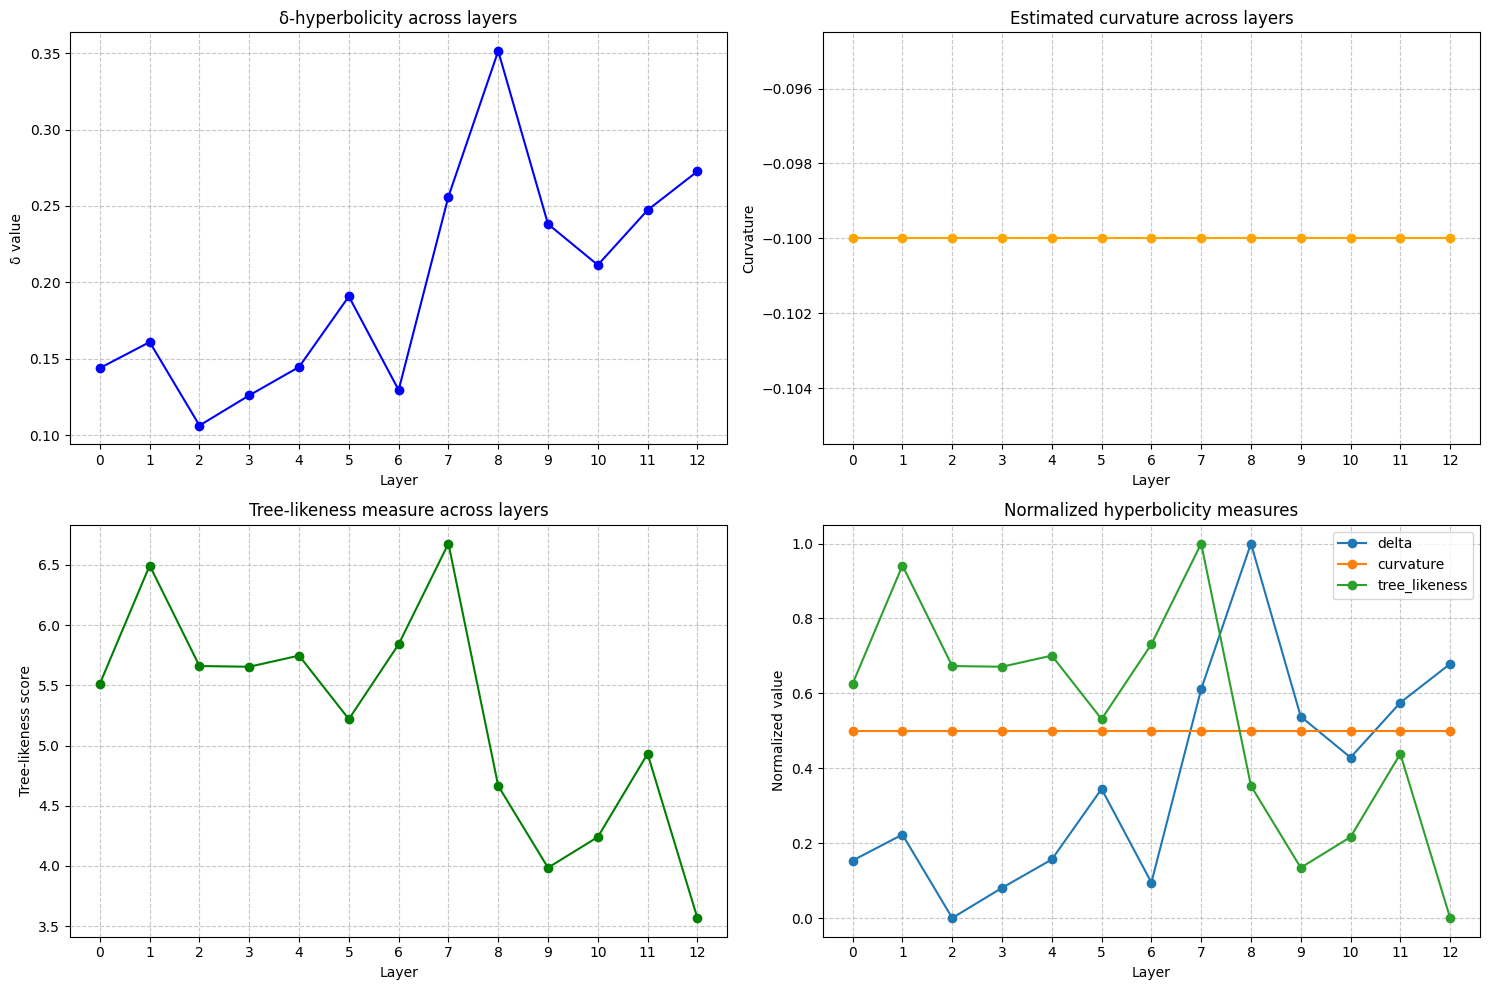

Plotting dependency correlations...


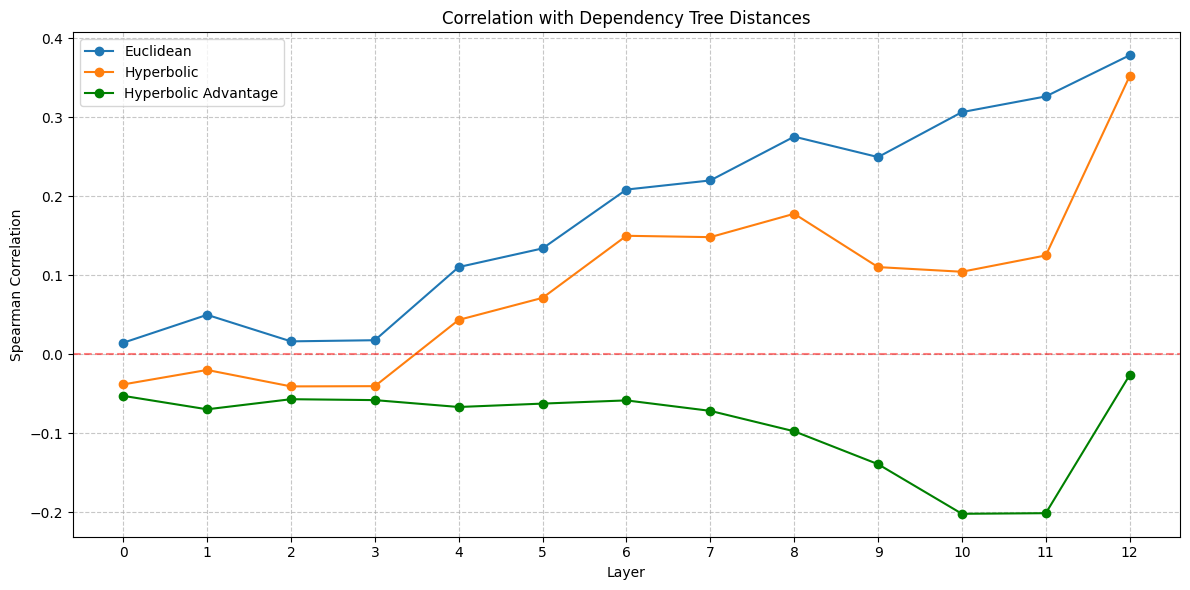

Plotting Jaccard similarities...


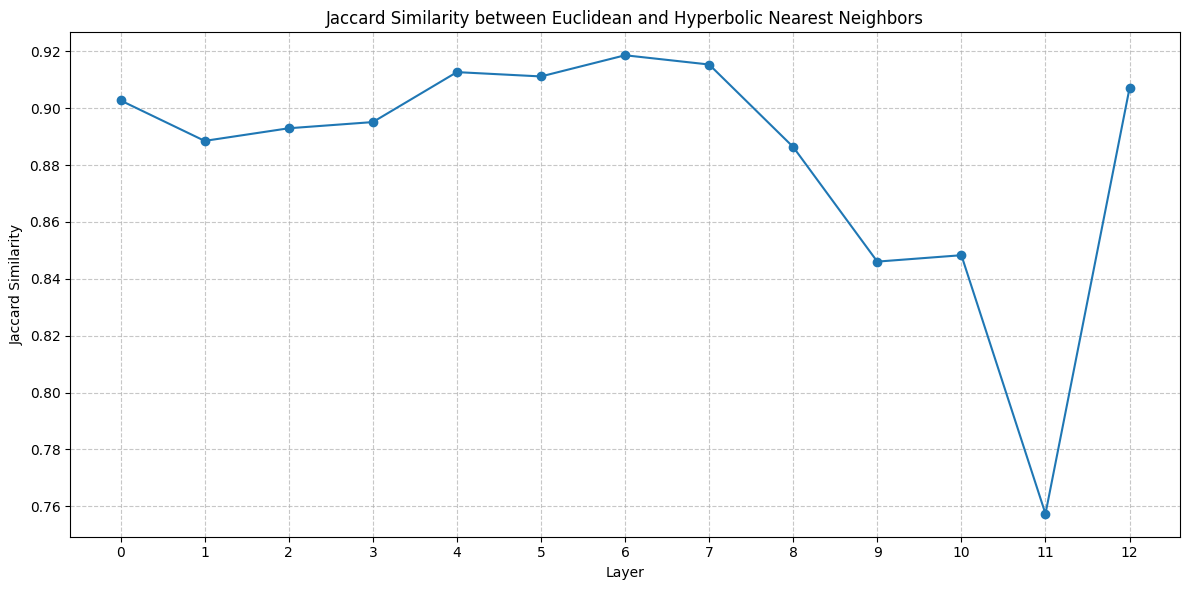

In [24]:
# Visualizations
print("\nCreating visualizations...")

print("Plotting hyperbolicity metrics...")
plot_hyperbolicity_metrics(hyperbolicity_metrics)
plt.savefig('hyperbolicity_metrics_50.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Plotting dependency correlations...")
plot_dependency_correlation(dependency_correlations)
plt.savefig('dependency_correlation_50.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Plotting Jaccard similarities...")
plot_jaccard_similarity(jaccard_similarities)
plt.savefig('jaccard_similarity_50.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [24]:
def visualize_layer_progression(token_embeddings, manifold=None, figsize=(20, 15)):
    if manifold is None:
        # Use the first embedding to determine dimension
        first_layer = list(token_embeddings.keys())[0]
        first_batch = token_embeddings[first_layer][0]
        dim = first_batch.shape[-1]
        manifold = PoincareManifold(dim=dim)
    
    # Take first sentence for visualization
    first_sentence = [embs[0] for layer_idx, embs in token_embeddings.items()]
    
    # Create 2D embeddings using PCA for each layer
    poincare_2d_embeddings = []
    
    for sent_embeddings in first_sentence:
        # Make sure tensor is on CPU before converting to numpy
        if sent_embeddings.is_cuda:
            sent_embeddings = sent_embeddings.cpu()
            
        # Apply PCA to reduce to 2D
        pca = PCA(n_components=2)
        embeddings_2d = torch.tensor(pca.fit_transform(sent_embeddings.numpy()))
        
        # Project to Poincaré ball
        poincare_embeddings = manifold.euclidean_to_poincare(embeddings_2d)
        poincare_2d_embeddings.append(poincare_embeddings)
    
    # Visualize
    num_layers = len(token_embeddings)
    ncols = 4  # Number of columns in the grid
    nrows = (num_layers + ncols - 1) // ncols  # Number of rows needed
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    for i, (layer_idx, embeddings) in enumerate(zip(sorted(token_embeddings.keys()), poincare_2d_embeddings)):
        ax = axes[i]
        
        # Draw boundary of Poincaré disk
        circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--', alpha=0.7)
        ax.add_patch(circle)
        
        # Plot points
        ax.scatter(
            embeddings[:, 0].numpy(),
            embeddings[:, 1].numpy(),
            alpha=0.8
        )
        
        ax.set_title(f'Layer {layer_idx}')
        ax.set_xlim(-1.1, 1.1)
        ax.set_ylim(-1.1, 1.1)
        ax.set_aspect('equal')
        ax.grid(False)
    
    # Hide unused subplots
    for i in range(len(poincare_2d_embeddings), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle("Evolution of Embeddings Across BERT Layers", fontsize=16, y=1.02)

Visualizing layer progression...


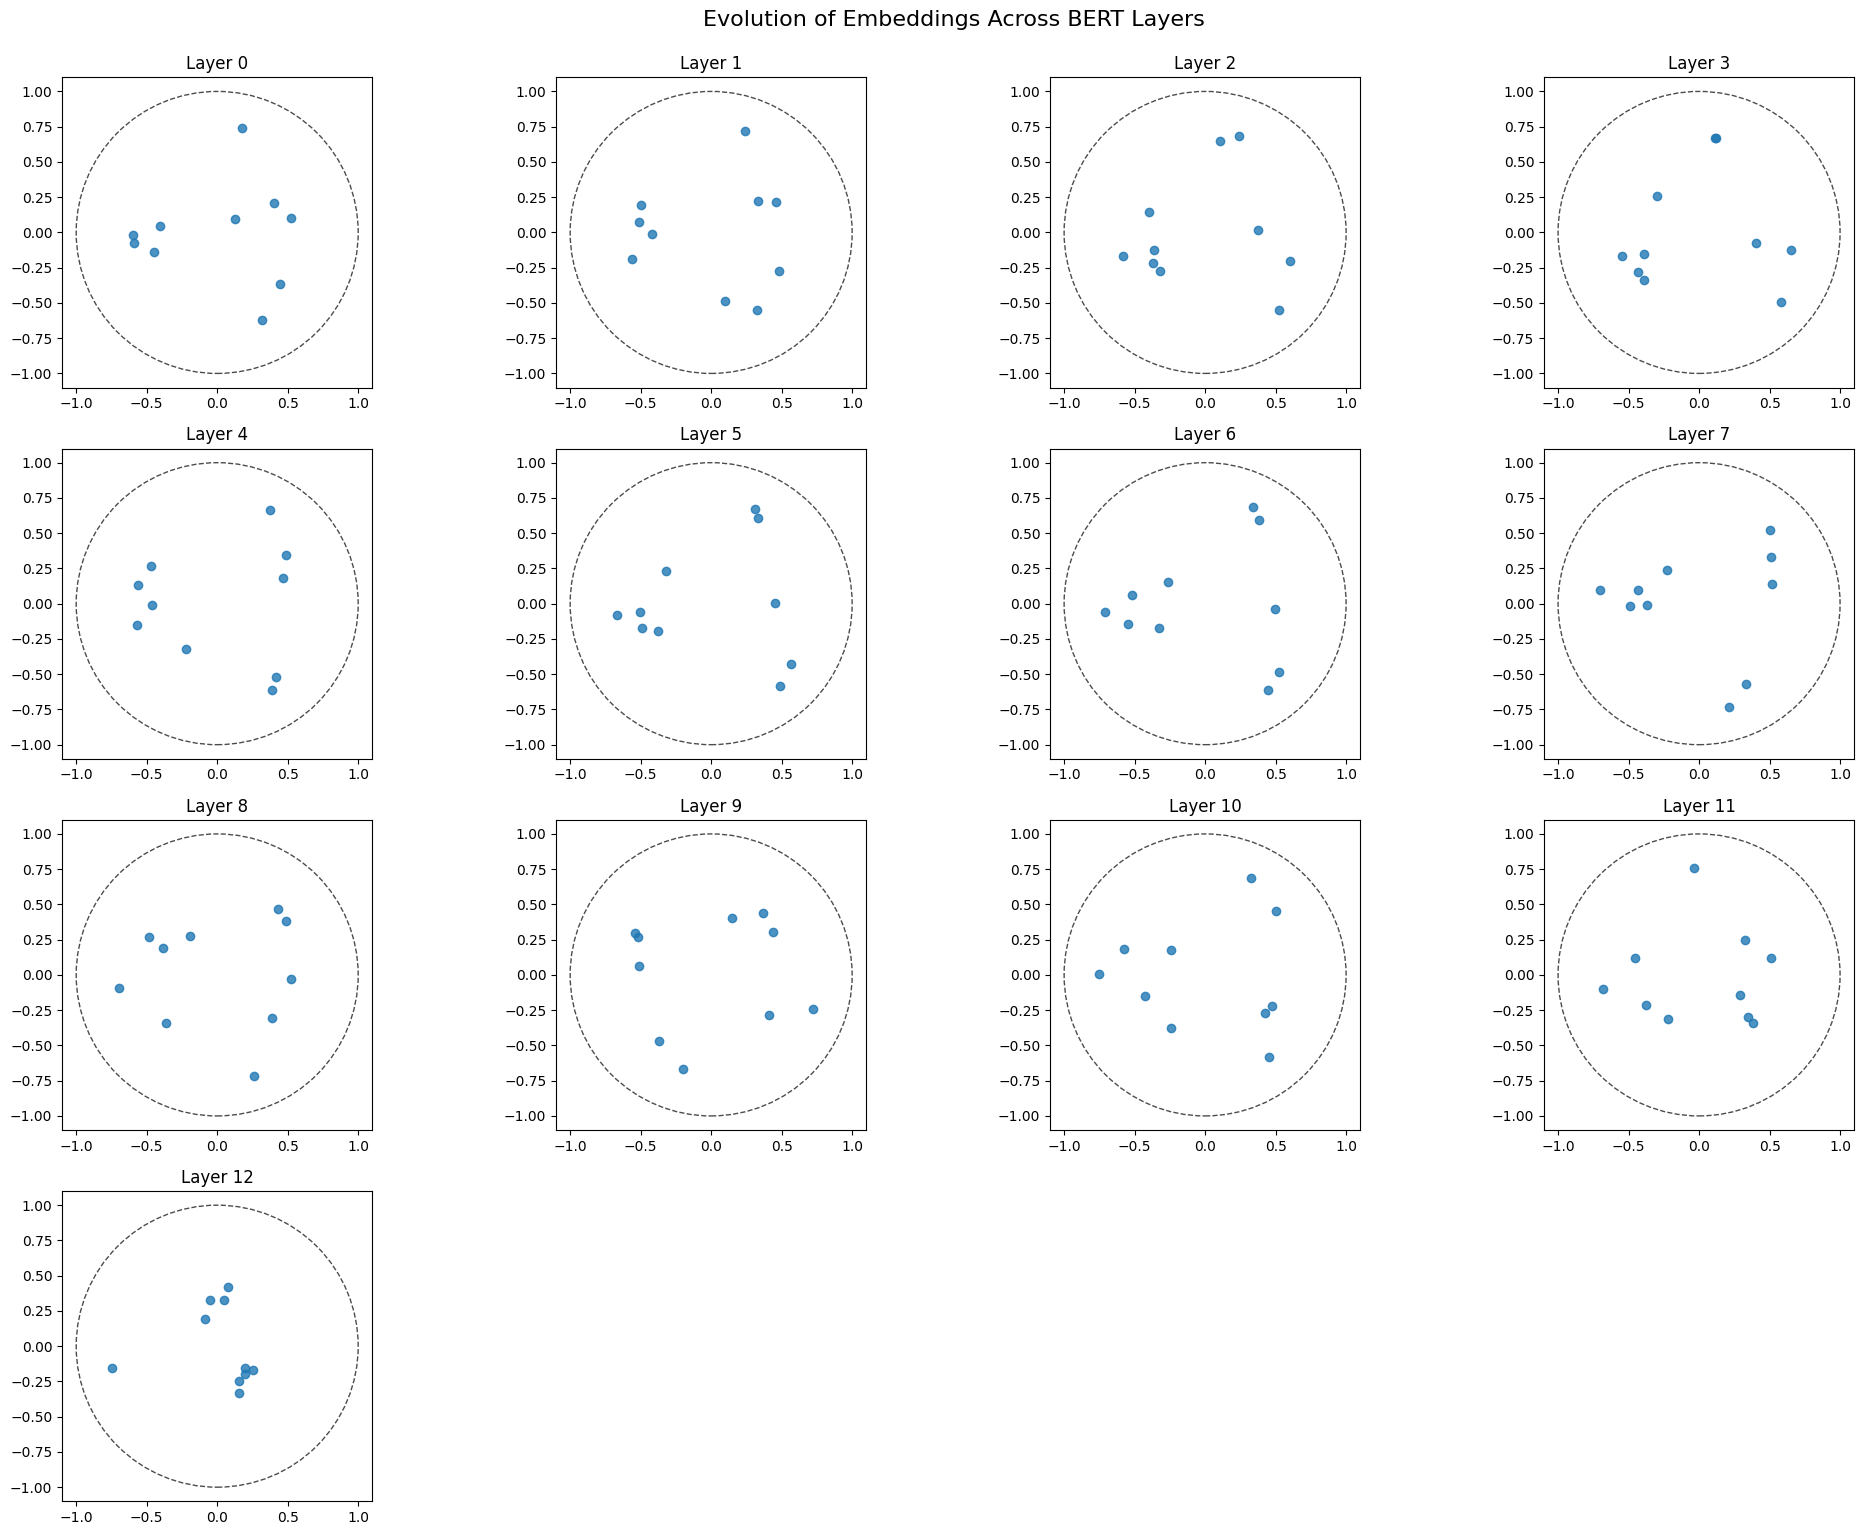

In [26]:
print("Visualizing layer progression...")
visualize_layer_progression(token_embeddings)
plt.savefig('layer_progression_50.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# 9. Visualize a specific layer and sentence in the Poincaré disk
layer_idx = 6  # Middle layer
sent_idx = 0
sent_embeddings = token_embeddings[layer_idx][sent_idx]
sent_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][sent_idx])[1:-1][:sent_embeddings.shape[0]]
sent_tree = dependency_trees[sent_idx]

manifold = PoincareManifold(dim=sent_embeddings.shape[1])
poincare_embeddings = manifold.euclidean_to_poincare(sent_embeddings)

In [23]:
def visualize_dependency_tree(tokens, tree, embeddings, manifold=None, figsize=(10, 8)):
    """
    Visualize a dependency tree in the Poincaré disk.
    
    Args:
        tokens: List of tokens in the sentence
        tree: Dependency tree as a list of (parent_idx, child_idx) pairs
        embeddings: Token embeddings in the Poincaré ball
        manifold: PoincareManifold object
        figsize: Figure size
    """
    if manifold is None:
        manifold = PoincareManifold(dim=embeddings.shape[1])
    
    # Move embeddings to CPU if they're on GPU
    if embeddings.is_cuda:
        embeddings = embeddings.cpu()
    
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    embeddings_2d = torch.tensor(pca.fit_transform(embeddings.numpy()))
    
    # Project to Poincaré ball
    poincare_embeddings = manifold.euclidean_to_poincare(embeddings_2d)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Draw boundary of Poincaré disk
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='--')
    plt.gca().add_patch(circle)
    
    # Draw nodes
    plt.scatter(
        poincare_embeddings[:, 0].numpy(),
        poincare_embeddings[:, 1].numpy(),
        s=100,
        alpha=0.8
    )
    
    # Add token labels
    for i, token in enumerate(tokens):
        plt.annotate(
            token,
            (poincare_embeddings[i, 0].item(), poincare_embeddings[i, 1].item()),
            fontsize=10,
            weight='bold',
            alpha=0.9,
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
        )
    
    # Draw edges
    for parent, child in tree:
        x1, y1 = poincare_embeddings[parent, 0].item(), poincare_embeddings[parent, 1].item()
        x2, y2 = poincare_embeddings[child, 0].item(), poincare_embeddings[child, 1].item()
        
        # Draw straight line (approximation of geodesic)
        plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.4)
    
    plt.title("Dependency Tree in Poincaré Disk")
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.grid(False)
    plt.tight_layout()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Visualizing dependency tree for sentence 0 at layer 6...


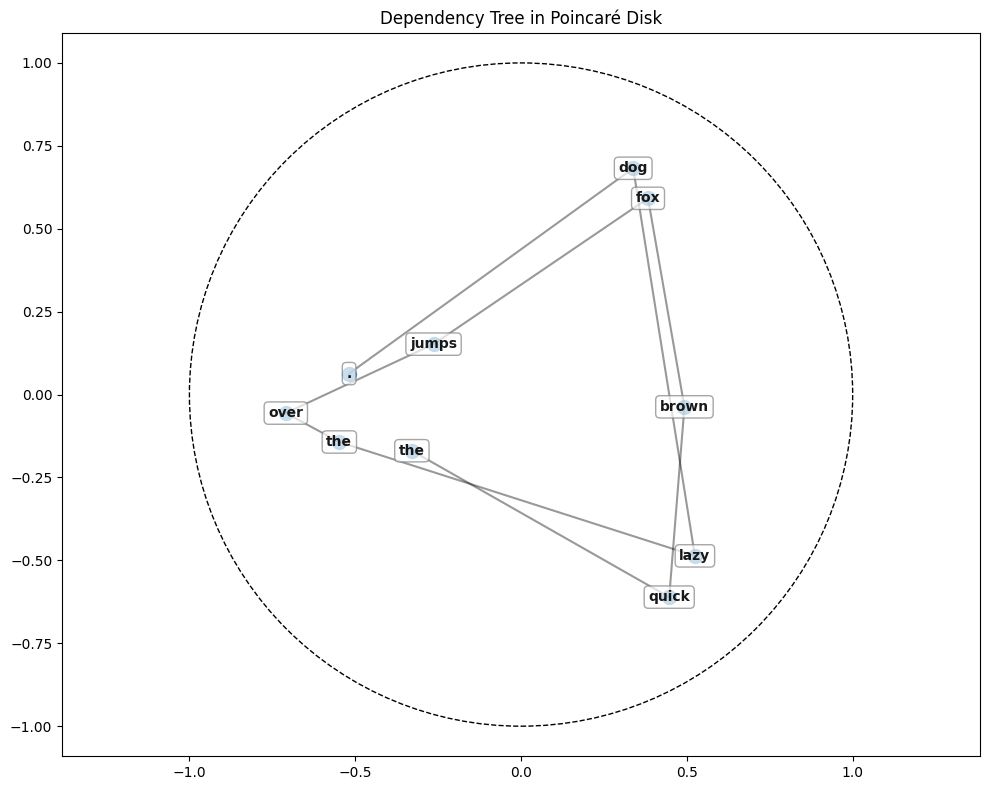

In [28]:
print(f"Visualizing dependency tree for sentence {sent_idx} at layer {layer_idx}...")
visualize_dependency_tree(sent_tokens, sent_tree, sent_embeddings, manifold)
plt.savefig('dependency_tree_visualization_50.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

---

---

In [29]:
# !pip install conllu

In [34]:
# # STEP 1: Load real UD sentences and dependency trees
from conllu import parse_incr

def load_ud_treebank(filepath, max_sentences=50):
    sentences = []
    trees = []

    with open(filepath, "r", encoding="utf-8") as f:
        for i, tokenlist in enumerate(parse_incr(f)):
            if i >= max_sentences:
                break
            tokens = [tok["form"] for tok in tokenlist if isinstance(tok["id"], int)]
            sentence = " ".join(tokens)
            sentences.append(sentence)

            tree = []
            for tok in tokenlist:
                if isinstance(tok["id"], int):
                    child = tok["id"] - 1
                    head = tok["head"] - 1 if tok["head"] > 0 else -1  # root has head=0
                    if head >= 0:
                        tree.append((head, child))
            trees.append(tree)

    return sentences, trees

# filepath = "en_ewt-ud-train.conllu"
# sentences, dependency_trees = load_ud_treebank(filepath, max_sentences=8000)
# print(f"Loaded {len(sentences)} real UD sentences.")

In [31]:
# sentences

In [25]:
def extract_bert_embeddings(model, tokenizer, sentences, layer_indices=None):
    model.eval()
    num_layers = model.config.num_hidden_layers + 1  # +1 for embedding layer
    if layer_indices is None:
        layer_indices = list(range(num_layers))

    batch_size = 8
    all_embeddings = {layer_idx: [] for layer_idx in layer_indices}
    attention_masks_list = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]
        inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        # Store attention masks for this batch
        attention_masks_batch = inputs['attention_mask'].cpu()

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # tuple: (13, batch, seq_len, hidden_dim)
            
            # Process each sentence in the batch
            for j in range(len(batch_sentences)):
                # Store the attention mask for this sentence
                attention_masks_list.append(attention_masks_batch[j])
                
                # Store embeddings for each layer for this sentence
                for layer_idx in layer_indices:
                    all_embeddings[layer_idx].append(hidden_states[layer_idx][j])

    return all_embeddings, attention_masks_list

def extract_token_embeddings(all_embeddings, attention_masks, remove_special_tokens=True):
    """
    Extract embeddings for individual tokens, optionally removing special tokens.
    
    Args:
        all_embeddings: Dictionary mapping layer indices to embeddings
        attention_masks: Attention masks from tokenizer
        remove_special_tokens: Whether to remove special tokens ([CLS], [SEP], etc.)
        
    Returns:
        dict: Dictionary mapping layer indices to lists of token embeddings
    """
    token_embeddings = {}
    
    for layer_idx, layer_embeddings in all_embeddings.items():
        batch_token_embeddings = []
        
        for i in range(len(layer_embeddings)):
            if i >= len(attention_masks):
                print(f"Warning: Misaligned attention mask for sample {i}. Skipping.")
                continue
                
            # Get embeddings for this sentence
            embeddings = layer_embeddings[i]
            mask = attention_masks[i]
            
            # Get indices of real tokens (excluding special tokens if requested)
            if remove_special_tokens:
                # The first token is [CLS], so exclude it
                start_idx = 1
                # Find the position of [SEP] and exclude it too
                sep_pos = torch.tensor(mask).sum().item() - 1
                indices = list(range(start_idx, sep_pos))
            else:
                # Include all tokens with attention mask == 1
                indices = [j for j in range(len(mask)) if mask[j] == 1]
            
            # Extract embeddings for these tokens
            sent_token_embeddings = embeddings[indices]
            batch_token_embeddings.append(sent_token_embeddings)
        
        token_embeddings[layer_idx] = batch_token_embeddings
    
    return token_embeddings

Setting up BERT model...
Loading real UD sentences...
Loaded 5000 UD sentences.
Computing dependency distances...
Extracting BERT embeddings...

Analyzing hyperbolicity across layers...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...

Analyzing correlation with dependency trees...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...

Analyzing syntax-semantics separation...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing lay

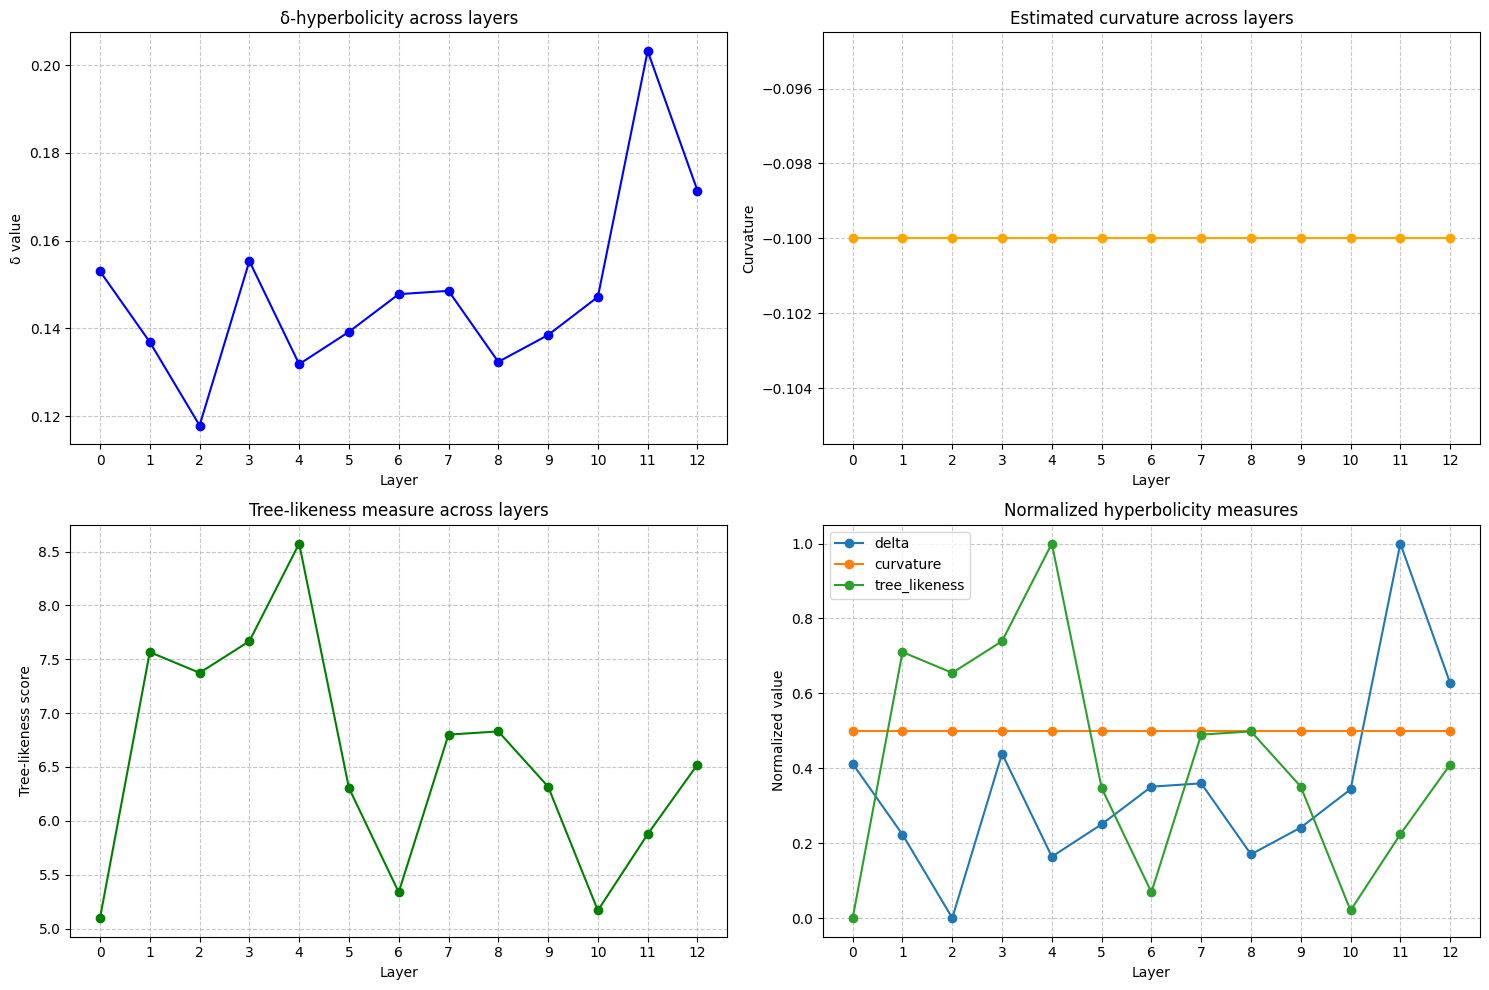

Plotting dependency correlations...


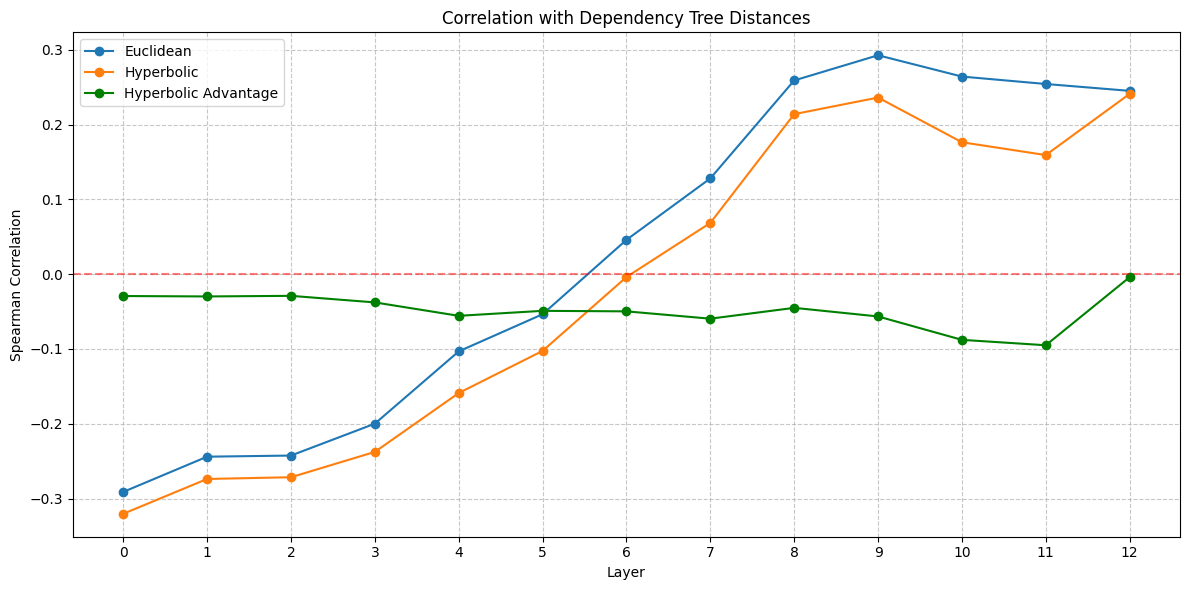

Plotting Jaccard similarities...


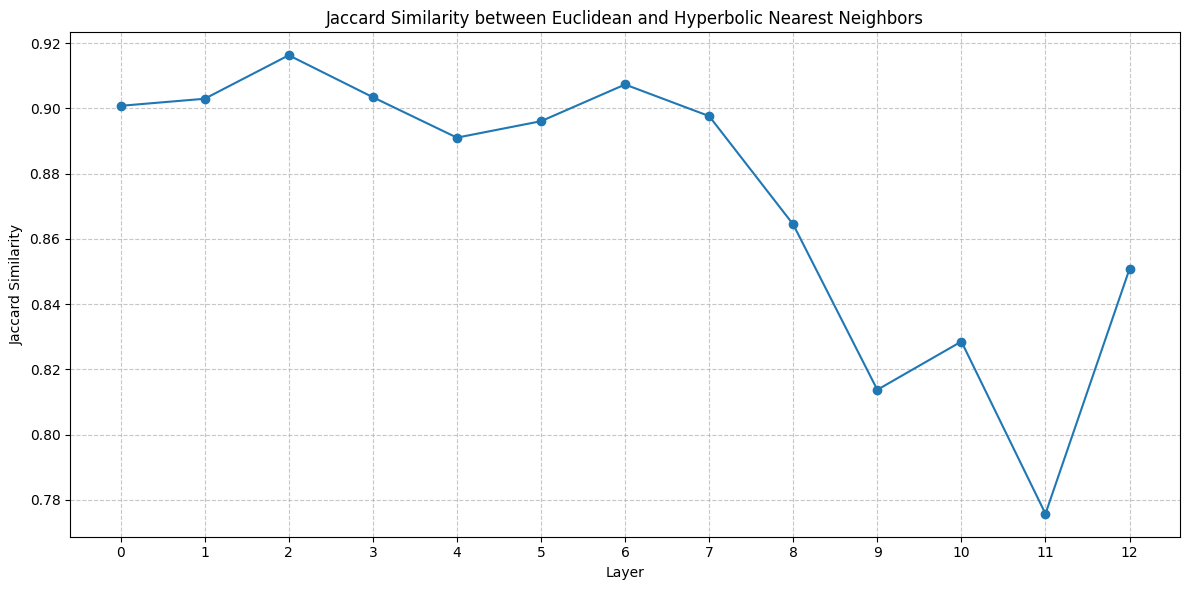

Visualizing layer progression...


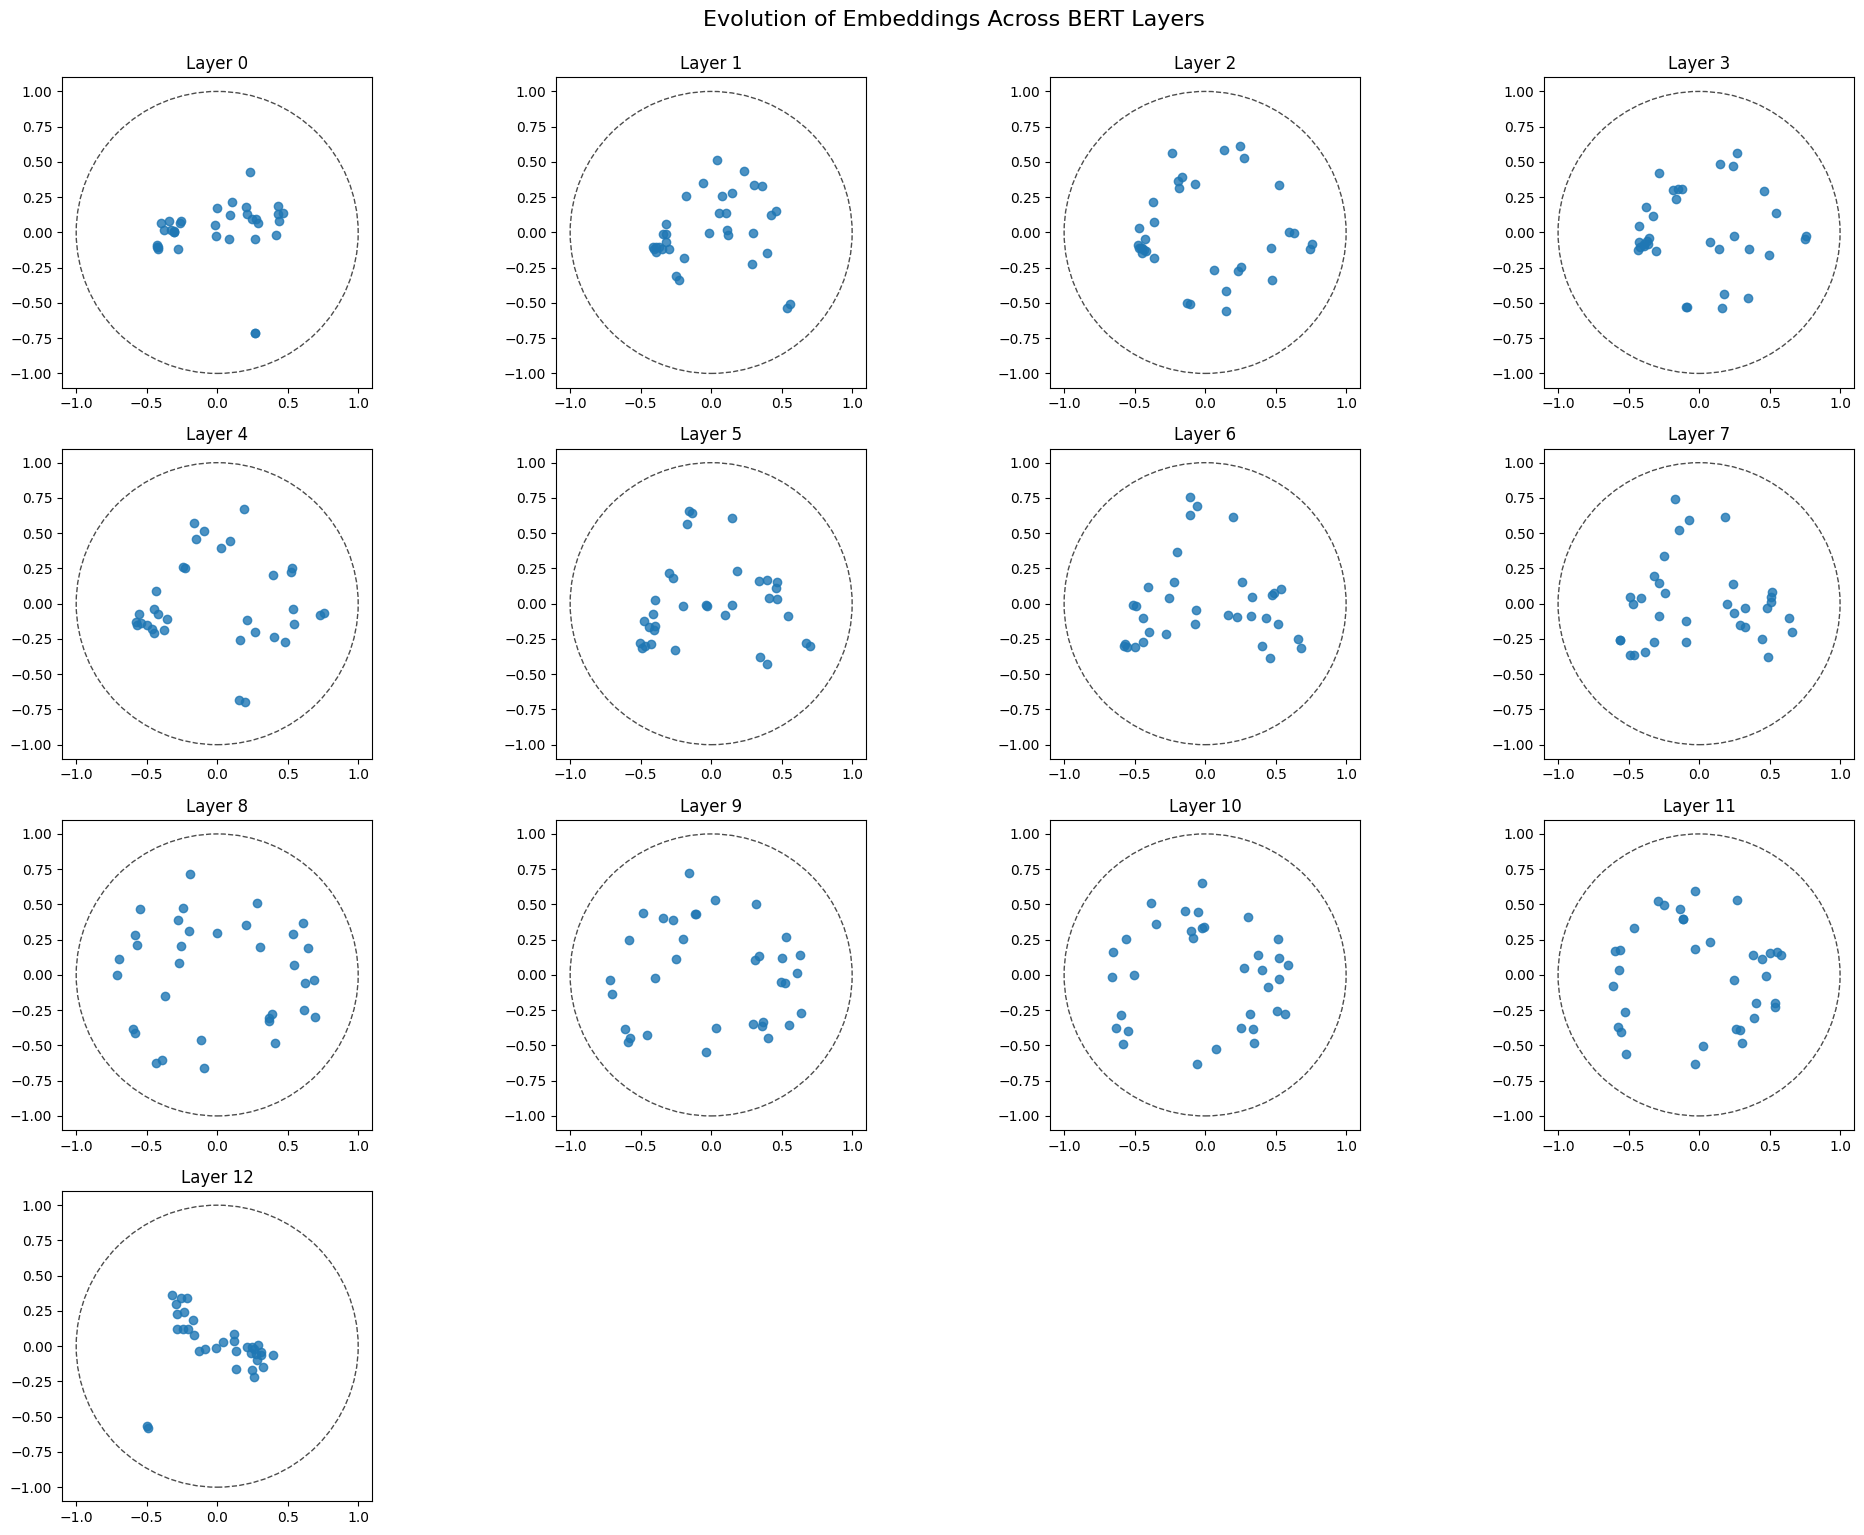

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Visualizing dependency tree for sentence 0 at layer 6...


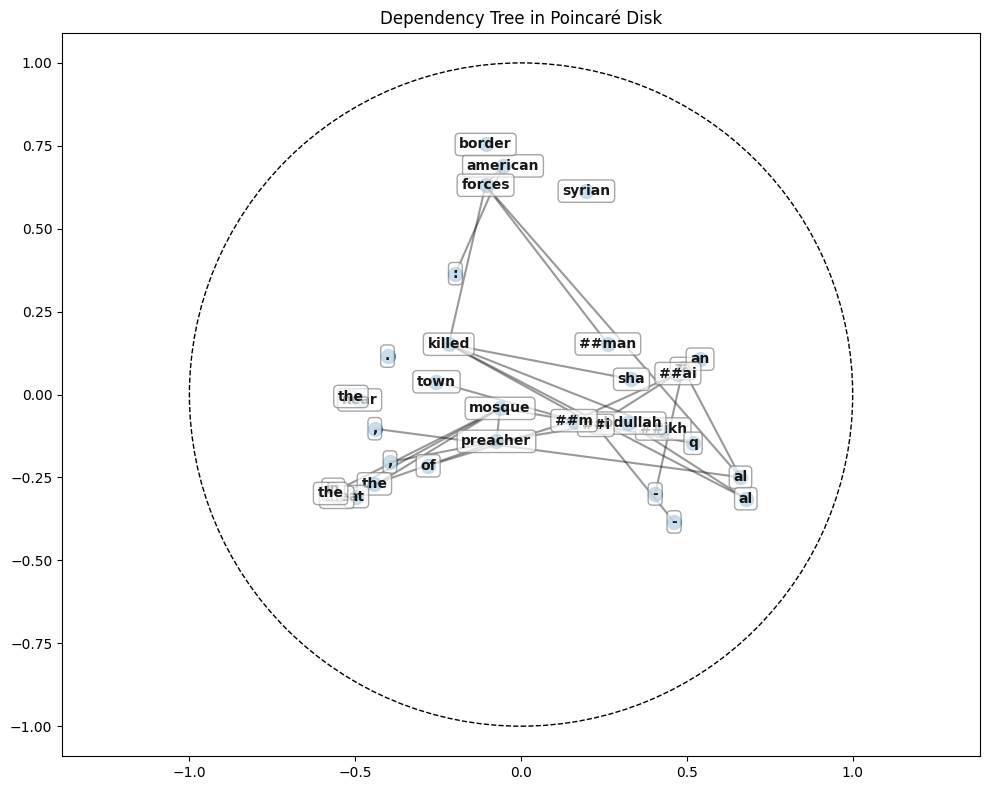

In [33]:
# === STEP 1: Load real UD data ===
from conllu import parse_incr

def load_ud_treebank(filepath, max_sentences=50):
    sentences = []
    trees = []

    with open(filepath, "r", encoding="utf-8") as f:
        for i, tokenlist in enumerate(parse_incr(f)):
            if i >= max_sentences:
                break
            tokens = [tok["form"] for tok in tokenlist if isinstance(tok["id"], int)]
            sentence = " ".join(tokens)
            sentences.append(sentence)

            tree = []
            for tok in tokenlist:
                if isinstance(tok["id"], int):
                    child = tok["id"] - 1
                    head = tok["head"] - 1 if tok["head"] > 0 else -1  # root has head=0
                    if head >= 0:
                        tree.append((head, child))
            trees.append(tree)

    return sentences, trees

# === STEP 2: Load model and tokenizer ===
print("Setting up BERT model...")
model, tokenizer = load_bert_model("bert-base-uncased")

# === STEP 3: Load UD sentences and trees ===
print("Loading real UD sentences...")
filepath = "en_ewt-ud-train.conllu"  # path to your downloaded file
sentences, dependency_trees = load_ud_treebank(filepath, max_sentences=5000)
print(f"Loaded {len(sentences)} UD sentences.")

# === STEP 4: Compute dependency distance matrices ===
print("Computing dependency distances...")
dependency_distances = compute_dependency_distances(dependency_trees)

# === STEP 5: Extract BERT embeddings ===
print("Extracting BERT embeddings...")
all_embeddings, attention_masks = extract_bert_embeddings(model, tokenizer, sentences)

# Convert attention masks to list-of-lists if needed
if isinstance(attention_masks[0], torch.Tensor):
    attention_masks = [a.cpu().numpy().tolist() for a in attention_masks]

token_embeddings = extract_token_embeddings(all_embeddings, attention_masks)

# === STEP 6: Analyze hyperbolicity ===
print("\nAnalyzing hyperbolicity across layers...")
hyperbolicity_metrics = compute_layer_hyperbolicity(token_embeddings)

# === STEP 7: Correlate BERT embeddings with syntax trees ===
print("\nAnalyzing correlation with dependency trees...")
dependency_correlations = analyze_dependency_correlation(token_embeddings, dependency_distances)

# === STEP 8: Syntax-Semantics separation ===
print("\nAnalyzing syntax-semantics separation...")
jaccard_similarities = analyze_syntax_semantics_separation(token_embeddings)

# === STEP 9: Visualizations ===
print("\nCreating visualizations...")

print("Plotting hyperbolicity metrics...")
plot_hyperbolicity_metrics(hyperbolicity_metrics)
plt.savefig('hyperbolicity_metrics_ud.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Plotting dependency correlations...")
plot_dependency_correlation(dependency_correlations)
plt.savefig('dependency_correlation_ud.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Plotting Jaccard similarities...")
plot_jaccard_similarity(jaccard_similarities)
plt.savefig('jaccard_similarity_ud.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Visualizing layer progression...")
visualize_layer_progression(token_embeddings)
plt.savefig('layer_progression_ud.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# === STEP 10: Optional — Visualize one sentence in detail ===
layer_idx = 6  # or any other
sent_idx = 0   # index of sentence to visualize

sent_embeddings = token_embeddings[layer_idx][sent_idx]
sent_tokens = tokenizer.convert_ids_to_tokens(
    tokenizer(sentences[sent_idx], return_tensors="pt")['input_ids'][0]
)[1:-1][:sent_embeddings.shape[0]]

sent_tree = dependency_trees[sent_idx]

manifold = PoincareManifold(dim=sent_embeddings.shape[1])
poincare_embeddings = manifold.euclidean_to_poincare(sent_embeddings)

print(f"Visualizing dependency tree for sentence {sent_idx} at layer {layer_idx}...")
visualize_dependency_tree(sent_tokens, sent_tree, sent_embeddings, manifold)
plt.savefig('dependency_tree_visualization_ud.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [34]:
sentences[:20]

['Al - Zaman : American forces killed Shaikh Abdullah al - Ani , the preacher at the mosque in the town of Qaim , near the Syrian border .',
 '[ This killing of a respected cleric will be causing us trouble for years to come . ]',
 'DPA : Iraqi authorities announced that they had busted up 3 terrorist cells operating in Baghdad .',
 'Two of them were being run by 2 officials of the Ministry of the Interior !',
 'The MoI in Iraq is equivalent to the US FBI , so this would be like having J. Edgar Hoover unwittingly employ at a high level members of the Weathermen bombers back in the 1960s .',
 'The third was being run by the head of an investment firm .',
 'You wonder if he was manipulating the market with his bombing targets .',
 'The cells were operating in the Ghazaliyah and al - Jihad districts of the capital .',
 "Although the announcement was probably made to show progress in identifying and breaking up terror cells , I do n't find the news that the Baathists continue to penetrate 

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Visualizing dependency tree for sentence -4 at layer 6...


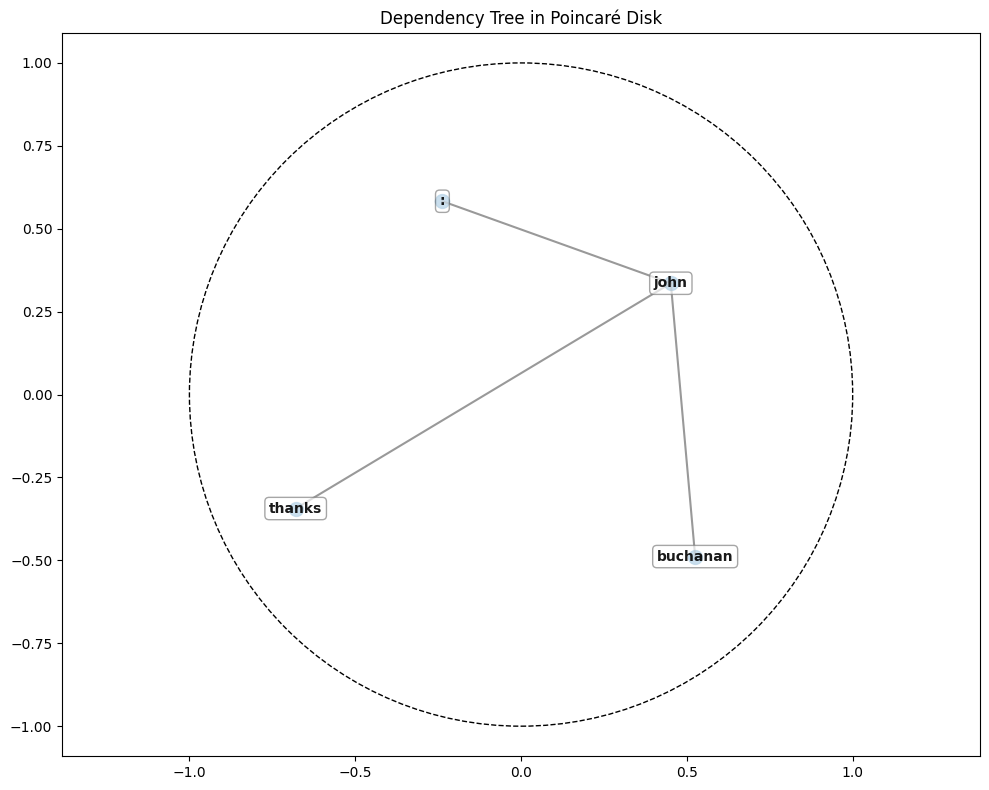

In [35]:
# === STEP 10: Optional — Visualize one sentence in detail ===
layer_idx = 6  # or any other
sent_idx = -4   # index of sentence to visualize

sent_embeddings = token_embeddings[layer_idx][sent_idx]
sent_tokens = tokenizer.convert_ids_to_tokens(
    tokenizer(sentences[sent_idx], return_tensors="pt")['input_ids'][0]
)[1:-1][:sent_embeddings.shape[0]]

sent_tree = dependency_trees[sent_idx]

manifold = PoincareManifold(dim=sent_embeddings.shape[1])
poincare_embeddings = manifold.euclidean_to_poincare(sent_embeddings)

print(f"Visualizing dependency tree for sentence {sent_idx} at layer {layer_idx}...")
visualize_dependency_tree(sent_tokens, sent_tree, sent_embeddings, manifold)
plt.savefig('dependency_tree_visualization_ud.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [38]:
def compute_q_scores(euclidean_embeddings, hyperbolic_embeddings, dependency_distances, K=10):
    """
    Compute Q-scores for both Euclidean and hyperbolic embeddings compared to dependency tree distances.
    
    Args:
        euclidean_embeddings: Original BERT embeddings
        hyperbolic_embeddings: Embeddings projected to Poincaré ball
        dependency_distances: Ground truth dependency tree distances
        K: Parameter for Q-local (number of nearest neighbors)
        
    Returns:
        Dictionary with Q-scores for both embedding types
    """
    # Compute distance matrices
    n = euclidean_embeddings.shape[0]
    
    # Euclidean distances
    euclidean_distances = torch.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            euclidean_distances[i, j] = torch.norm(euclidean_embeddings[i] - euclidean_embeddings[j])
            euclidean_distances[j, i] = euclidean_distances[i, j]
    
    # Normalize distances
    euclidean_distances = euclidean_distances / euclidean_distances.max()
    
    # Hyperbolic distances
    manifold = PoincareManifold(dim=hyperbolic_embeddings.shape[1])
    hyperbolic_distances = torch.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            hyperbolic_distances[i, j] = manifold.distance(
                hyperbolic_embeddings[i].unsqueeze(0),
                hyperbolic_embeddings[j].unsqueeze(0)
            )
            hyperbolic_distances[j, i] = hyperbolic_distances[i, j]
    
    # Normalize distances
    hyperbolic_distances = hyperbolic_distances / hyperbolic_distances.max()
    
    # Normalize dependency distances
    dep_distances = dependency_distances / dependency_distances.max()
    
    # Compute rank matrices (convert to numpy for easier rank computation)
    euclidean_dist_np = euclidean_distances.numpy()
    hyperbolic_dist_np = hyperbolic_distances.numpy()
    dep_dist_np = dep_distances.numpy()
    
    # Compute ranks for each point
    euclidean_ranks = np.zeros_like(euclidean_dist_np)
    hyperbolic_ranks = np.zeros_like(hyperbolic_dist_np)
    dep_ranks = np.zeros_like(dep_dist_np)
    
    for i in range(n):
        euclidean_ranks[i] = np.argsort(np.argsort(euclidean_dist_np[i]))
        hyperbolic_ranks[i] = np.argsort(np.argsort(hyperbolic_dist_np[i]))
        dep_ranks[i] = np.argsort(np.argsort(dep_dist_np[i]))
    
    # Compute co-ranking matrices
    Q_euclidean = compute_co_ranking_matrix(dep_ranks, euclidean_ranks)
    Q_hyperbolic = compute_co_ranking_matrix(dep_ranks, hyperbolic_ranks)
    
    # Compute Q-scores
    Q_euclidean_local, Q_euclidean_global = compute_q_local_global(Q_euclidean, K)
    Q_hyperbolic_local, Q_hyperbolic_global = compute_q_local_global(Q_hyperbolic, K)
    
    return {
        'euclidean': {
            'local': Q_euclidean_local,
            'global': Q_euclidean_global,
            'total': (Q_euclidean_local + Q_euclidean_global) / 2
        },
        'hyperbolic': {
            'local': Q_hyperbolic_local,
            'global': Q_hyperbolic_global,
            'total': (Q_hyperbolic_local + Q_hyperbolic_global) / 2
        }
    }

def compute_co_ranking_matrix(R_high, R_low):
    """
    Compute co-ranking matrix from rank matrices.
    
    Args:
        R_high: High-dimensional ranks (dependency tree)
        R_low: Low-dimensional ranks (embedding space)
        
    Returns:
        Co-ranking matrix Q
    """
    N = R_high.shape[0]
    Q = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            k = int(R_high[i, j])
            l = int(R_low[i, j])
            Q[k, l] += 1
    
    return Q

def compute_q_local_global(Q, K):
    N = Q.shape[0]
    Q_local = np.sum(Q[:K, :K]) / max(K * N, 1)
    Q_global = np.sum(Q[K:, K:]) / max((N - K) * N, 1)
    return Q_local, Q_global

def analyze_layer_hyperbolicity_with_qscores(token_embeddings, dependency_distances, Ks=[5, 10, 20], manifold=None):
    """
    Analyze hyperbolicity of each layer with Q-scores.
    
    Args:
        token_embeddings: Dictionary mapping layer indices to token embeddings
        dependency_distances: List of dependency distance matrices
        Ks: List of K values for Q-local calculation
        manifold: PoincareManifold object (if None, one will be created)
        
    Returns:
        dict: Dictionary with hyperbolicity metrics and Q-scores for each layer
    """
    if manifold is None:
        # Use the first embedding to determine dimension
        first_layer = list(token_embeddings.keys())[0]
        first_batch = token_embeddings[first_layer][0]
        dim = first_batch.shape[-1]
        manifold = PoincareManifold(dim=dim)
    
    # Initialize metrics
    metrics = {
        'delta': [],       # δ-hyperbolicity
        'curvature': [],   # Estimated curvature
        'tree_likeness': [], # Tree-likeness score
        'q_scores': {}     # Q-scores for different K values
    }
    
    for K in Ks:
        metrics['q_scores'][K] = {
            'euclidean': {'local': [], 'global': [], 'total': []},
            'hyperbolic': {'local': [], 'global': [], 'total': []},
            'advantage': {'local': [], 'global': [], 'total': []}
        }
    
    # Process each layer
    for layer_idx in sorted(token_embeddings.keys()):
        print(f"Processing layer {layer_idx} with Q-scores...")
        
        # Collect embeddings and compute metrics as before
        layer_embeddings = []
        for sent_idx, sent_embeddings in enumerate(token_embeddings[layer_idx]):
            if sent_idx < len(dependency_distances):
                # Only include sentences with matching dependency distances
                if sent_embeddings.shape[0] == dependency_distances[sent_idx].shape[0]:
                    layer_embeddings.append((sent_embeddings, dependency_distances[sent_idx]))
        
        # Compute layer-wise metrics
        layer_delta = []
        layer_curvature = []
        layer_tree_likeness = []
        layer_q_scores = {K: [] for K in Ks}
        
        for euclidean_embeddings, dep_distances in layer_embeddings:
            # Project to Poincaré ball
            hyperbolic_embeddings = manifold.euclidean_to_poincare(euclidean_embeddings)
            
            # Compute pairwise distances (for delta and tree-likeness)
            n = hyperbolic_embeddings.shape[0]
            distances = torch.zeros((n, n))
            for i in range(n):
                for j in range(i+1, n):
                    dist = manifold.distance(
                        hyperbolic_embeddings[i].unsqueeze(0),
                        hyperbolic_embeddings[j].unsqueeze(0)
                    )
                    distances[i, j] = dist
                    distances[j, i] = dist
            
            # Compute delta-hyperbolicity
            delta = compute_delta_hyperbolicity(distances)
            layer_delta.append(delta)
            
            # Estimate curvature
            curvature = estimate_curvature(euclidean_embeddings)
            layer_curvature.append(curvature)
            
            # Compute tree-likeness
            tree_likeness = compute_tree_likeness(hyperbolic_embeddings, manifold)
            layer_tree_likeness.append(tree_likeness)
            
            # Compute Q-scores for different K values
            for K in Ks:
                q_scores = compute_q_scores(euclidean_embeddings, hyperbolic_embeddings, dep_distances, K)
                layer_q_scores[K].append(q_scores)
        
        # Aggregate metrics
        metrics['delta'].append(np.mean(layer_delta) if layer_delta else 0)
        metrics['curvature'].append(np.mean(layer_curvature) if layer_curvature else 0)
        metrics['tree_likeness'].append(np.mean(layer_tree_likeness) if layer_tree_likeness else 0)
        
        # Aggregate Q-scores
        for K in Ks:
            if layer_q_scores[K]:
                avg_euclidean_local = np.mean([q['euclidean']['local'] for q in layer_q_scores[K]])
                avg_euclidean_global = np.mean([q['euclidean']['global'] for q in layer_q_scores[K]])
                avg_euclidean_total = np.mean([q['euclidean']['total'] for q in layer_q_scores[K]])
                
                avg_hyperbolic_local = np.mean([q['hyperbolic']['local'] for q in layer_q_scores[K]])
                avg_hyperbolic_global = np.mean([q['hyperbolic']['global'] for q in layer_q_scores[K]])
                avg_hyperbolic_total = np.mean([q['hyperbolic']['total'] for q in layer_q_scores[K]])
                
                metrics['q_scores'][K]['euclidean']['local'].append(avg_euclidean_local)
                metrics['q_scores'][K]['euclidean']['global'].append(avg_euclidean_global)
                metrics['q_scores'][K]['euclidean']['total'].append(avg_euclidean_total)
                
                metrics['q_scores'][K]['hyperbolic']['local'].append(avg_hyperbolic_local)
                metrics['q_scores'][K]['hyperbolic']['global'].append(avg_hyperbolic_global)
                metrics['q_scores'][K]['hyperbolic']['total'].append(avg_hyperbolic_total)
                
                # Compute hyperbolic advantage
                metrics['q_scores'][K]['advantage']['local'].append(avg_hyperbolic_local - avg_euclidean_local)
                metrics['q_scores'][K]['advantage']['global'].append(avg_hyperbolic_global - avg_euclidean_global)
                metrics['q_scores'][K]['advantage']['total'].append(avg_hyperbolic_total - avg_euclidean_total)
            else:
                # Fill with zeros if no data
                for space in ['euclidean', 'hyperbolic', 'advantage']:
                    for metric in ['local', 'global', 'total']:
                        metrics['q_scores'][K][space][metric].append(0)
    
    return metrics

def plot_q_scores(metrics, K=10):
    """
    Plot Q-scores across layers.
    
    Args:
        metrics: Dictionary with hyperbolicity metrics and Q-scores
        K: K value for Q-local to plot
    """
    num_layers = len(metrics['delta'])
    layer_indices = list(range(num_layers))
    
    plt.figure(figsize=(15, 10))
    
    # Plot Q-local scores
    plt.subplot(2, 2, 1)
    plt.plot(layer_indices, metrics['q_scores'][K]['euclidean']['local'], 'o-', label='Euclidean')
    plt.plot(layer_indices, metrics['q_scores'][K]['hyperbolic']['local'], 'o-', label='Hyperbolic')
    plt.plot(layer_indices, metrics['q_scores'][K]['advantage']['local'], 'o-', label='Hyperbolic Advantage')
    plt.title(f'Q-local (K={K}) across layers')
    plt.xlabel('Layer')
    plt.ylabel('Q-local Score')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Plot Q-global scores
    plt.subplot(2, 2, 2)
    plt.plot(layer_indices, metrics['q_scores'][K]['euclidean']['global'], 'o-', label='Euclidean')
    plt.plot(layer_indices, metrics['q_scores'][K]['hyperbolic']['global'], 'o-', label='Hyperbolic')
    plt.plot(layer_indices, metrics['q_scores'][K]['advantage']['global'], 'o-', label='Hyperbolic Advantage')
    plt.title(f'Q-global (K={K}) across layers')
    plt.xlabel('Layer')
    plt.ylabel('Q-global Score')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Plot Q-total scores
    plt.subplot(2, 2, 3)
    plt.plot(layer_indices, metrics['q_scores'][K]['euclidean']['total'], 'o-', label='Euclidean')
    plt.plot(layer_indices, metrics['q_scores'][K]['hyperbolic']['total'], 'o-', label='Hyperbolic')
    plt.plot(layer_indices, metrics['q_scores'][K]['advantage']['total'], 'o-', label='Hyperbolic Advantage')
    plt.title(f'Q-total across layers')
    plt.xlabel('Layer')
    plt.ylabel('Q-total Score')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Plot comparative metrics
    plt.subplot(2, 2, 4)
    
    # Normalize metrics to [0, 1] range for comparison
    delta_norm = normalize_metric(metrics['delta'])
    tree_likeness_norm = normalize_metric(metrics['tree_likeness'])
    hyperbolic_advantage_norm = normalize_metric(metrics['q_scores'][K]['advantage']['total'])
    
    plt.plot(layer_indices, delta_norm, 'o-', label='Normalized δ-hyperbolicity')
    plt.plot(layer_indices, tree_likeness_norm, 'o-', label='Normalized Tree-likeness')
    plt.plot(layer_indices, hyperbolic_advantage_norm, 'o-', label='Normalized Hyperbolic Advantage')
    
    plt.title('Comparison of Hyperbolicity Measures')
    plt.xlabel('Layer')
    plt.ylabel('Normalized Value')
    plt.xticks(layer_indices)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('q_scores_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def normalize_metric(metric_values):
    """Normalize values to [0, 1] range."""
    values = np.array(metric_values)
    min_val = np.min(values)
    max_val = np.max(values)
    if max_val > min_val:
        return (values - min_val) / (max_val - min_val)
    else:
        return np.ones_like(values) * 0.5

def compare_methods_with_qscores(token_embeddings, dependency_distances, layer_idx=6, methods=None, Ks=[5, 10, 20]):
    """
    Compare different embedding methods using Q-scores.
    
    Args:
        token_embeddings: Dictionary mapping layer indices to token embeddings
        dependency_distances: List of dependency distance matrices
        layer_idx: Layer to use for comparison
        methods: Dictionary of embedding methods to compare
        Ks: List of K values for Q-local calculation
        
    Returns:
        dict: Dictionary with Q-scores for each method
    """
    if methods is None:
        # Default methods to compare
        methods = {
            'Euclidean': lambda x: x,  # Identity (original embeddings)
            'Hyperbolic': lambda x: PoincareManifold(dim=x.shape[1]).euclidean_to_poincare(x),
            'PCA-2D': lambda x: torch.tensor(PCA(n_components=2).fit_transform(x.numpy())) if not x.is_cuda else torch.tensor(PCA(n_components=2).fit_transform(x.cpu().numpy())),
            'MDS-2D': lambda x: torch.tensor(MDS(n_components=2).fit_transform(x.numpy())) if not x.is_cuda else torch.tensor(MDS(n_components=2).fit_transform(x.cpu().numpy())),
            'Isomap-2D': lambda x: torch.tensor(Isomap(n_components=2, n_neighbors=5).fit_transform(x.numpy())) if not x.is_cuda else torch.tensor(Isomap(n_components=2, n_neighbors=5).fit_transform(x.cpu().numpy())),
        }
    
    # Get embeddings for the selected layer
    layer_embeddings = []
    for sent_idx, sent_embeddings in enumerate(token_embeddings[layer_idx]):
        if sent_idx < len(dependency_distances):
            # Only include sentences with matching dependency distances
            if sent_embeddings.shape[0] == dependency_distances[sent_idx].shape[0]:
                layer_embeddings.append((sent_embeddings, dependency_distances[sent_idx]))
    
    # Initialize results
    results = {K: {method: {'local': [], 'global': [], 'total': []} for method in methods} for K in Ks}
    
    # Process each sentence
    for euclidean_embeddings, dep_distances in layer_embeddings:
        if euclidean_embeddings.shape[0] < 6:
            # Skip short sentences that break PCA/Isomap
            continue

        # Apply each method
        transformed_embeddings = {}
        for method_name, transform_fn in methods.items():
            try:
                transformed_embeddings[method_name] = transform_fn(euclidean_embeddings)
            except Exception as e:
                print(f"Error applying {method_name}: {e}")
                continue
        
        # Compute Q-scores for each method and K value
        for K in Ks:
            for method1_name in transformed_embeddings:
                for method2_name in transformed_embeddings:
                    if method1_name != method2_name:
                        # Only compare different methods
                        method1_embeddings = transformed_embeddings[method1_name]
                        method2_embeddings = transformed_embeddings[method2_name]
                        
                        # Compute distances for both methods
                        n = method1_embeddings.shape[0]
                        method1_distances = torch.zeros((n, n))
                        method2_distances = torch.zeros((n, n))
                        
                        for i in range(n):
                            for j in range(i+1, n):
                                # Handle different distance computations based on method
                                if method1_name == 'Hyperbolic':
                                    manifold = PoincareManifold(dim=method1_embeddings.shape[1])
                                    method1_distances[i, j] = manifold.distance(
                                        method1_embeddings[i].unsqueeze(0),
                                        method1_embeddings[j].unsqueeze(0)
                                    )
                                else:
                                    method1_distances[i, j] = torch.norm(method1_embeddings[i] - method1_embeddings[j])
                                    
                                if method2_name == 'Hyperbolic':
                                    manifold = PoincareManifold(dim=method2_embeddings.shape[1])
                                    method2_distances[i, j] = manifold.distance(
                                        method2_embeddings[i].unsqueeze(0),
                                        method2_embeddings[j].unsqueeze(0)
                                    )
                                else:
                                    method2_distances[i, j] = torch.norm(method2_embeddings[i] - method2_embeddings[j])
                                
                                method1_distances[j, i] = method1_distances[i, j]
                                method2_distances[j, i] = method2_distances[i, j]
                        
                        # Normalize distances
                        method1_distances = method1_distances / method1_distances.max()
                        method2_distances = method2_distances / method2_distances.max()
                        
                        # Compute rank matrices
                        method1_dist_np = method1_distances.numpy()
                        method2_dist_np = method2_distances.numpy()
                        dep_dist_np = dep_distances.numpy()
                        
                        method1_ranks = np.zeros_like(method1_dist_np)
                        method2_ranks = np.zeros_like(method2_dist_np)
                        dep_ranks = np.zeros_like(dep_dist_np)
                        
                        for i in range(n):
                            method1_ranks[i] = np.argsort(np.argsort(method1_dist_np[i]))
                            method2_ranks[i] = np.argsort(np.argsort(method2_dist_np[i]))
                            dep_ranks[i] = np.argsort(np.argsort(dep_dist_np[i]))
                        
                        # Compute co-ranking matrices
                        Q_method1 = compute_co_ranking_matrix(dep_ranks, method1_ranks)
                        Q_method2 = compute_co_ranking_matrix(dep_ranks, method2_ranks)
                        
                        # Compute Q-scores
                        Q_method1_local, Q_method1_global = compute_q_local_global(Q_method1, K)
                        Q_method2_local, Q_method2_global = compute_q_local_global(Q_method2, K)
                        
                        # Store results
                        results[K][method1_name]['local'].append(Q_method1_local)
                        results[K][method1_name]['global'].append(Q_method1_global)
                        results[K][method1_name]['total'].append((Q_method1_local + Q_method1_global) / 2)
                        
                        results[K][method2_name]['local'].append(Q_method2_local)
                        results[K][method2_name]['global'].append(Q_method2_global)
                        results[K][method2_name]['total'].append((Q_method2_local + Q_method2_global) / 2)
    
    # Average results
    avg_results = {K: {} for K in Ks}
    for K in Ks:
        for method_name in methods:
            if method_name in results[K] and results[K][method_name]['local']:
                avg_results[K][method_name] = {
                    'local': np.mean(results[K][method_name]['local']),
                    'global': np.mean(results[K][method_name]['global']),
                    'total': np.mean(results[K][method_name]['total'])
                }
            else:
                avg_results[K][method_name] = {'local': 0, 'global': 0, 'total': 0}
    
    return avg_results

def plot_method_comparison(avg_results, K=10):
    """
    Plot comparison of different embedding methods.
    
    Args:
        avg_results: Dictionary with average Q-scores for each method
        K: K value for Q-local to plot
    """
    methods = list(avg_results[K].keys())
    
    # Get scores
    q_local = [avg_results[K][method]['local'] for method in methods]
    q_global = [avg_results[K][method]['global'] for method in methods]
    q_total = [avg_results[K][method]['total'] for method in methods]
    
    # Set up plot
    plt.figure(figsize=(12, 8))
    x = np.arange(len(methods))
    width = 0.25
    
    # Plot bars
    plt.bar(x - width, q_local, width, label='Q-local')
    plt.bar(x, q_global, width, label='Q-global')
    plt.bar(x + width, q_total, width, label='Q-total')
    
    # Add labels and legend
    plt.xlabel('Method')
    plt.ylabel('Q-score')
    plt.title(f'Comparison of Embedding Methods (K={K})')
    plt.xticks(x, methods)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_comprehensive_analysis(token_embeddings, dependency_distances):
    """
    Run a comprehensive analysis of hyperbolicity and embedding quality.
    
    Args:
        token_embeddings: Dictionary mapping layer indices to token embeddings
        dependency_distances: List of dependency distance matrices
    """
    print("\n=== Running Comprehensive Hyperbolicity Analysis ===\n")
    
    # 1. Analyze hyperbolicity across layers with Q-scores
    print("Analyzing hyperbolicity across layers with Q-scores...")
    metrics = analyze_layer_hyperbolicity_with_qscores(token_embeddings, dependency_distances)
    
    # 2. Plot Q-scores
    print("Plotting Q-score analysis...")
    plot_q_scores(metrics)
    
    # 3. Compare different embedding methods
    print("Comparing different embedding methods...")
    mid_layer = len(token_embeddings) // 2
    method_results = compare_methods_with_qscores(token_embeddings, dependency_distances, layer_idx=mid_layer)
    
    # 4. Plot method comparison
    print("Plotting method comparison...")
    plot_method_comparison(method_results)
    
    # 5. Generate summary of findings
    print("\n=== Summary of Findings ===\n")
    
    # Determine if hyperbolic space is better overall
    hyperbolic_advantage = np.mean(metrics['q_scores'][10]['advantage']['total'])
    if hyperbolic_advantage > 0.05:
        print("✓ Hyperbolic space provides a substantial advantage over Euclidean space.")
    elif hyperbolic_advantage > 0:
        print("✓ Hyperbolic space provides a small advantage over Euclidean space.")
    else:
        print("✗ Euclidean space outperforms hyperbolic space for these embeddings.")
    
    # Identify best layers for hyperbolicity
    best_layer = np.argmax(metrics['q_scores'][10]['advantage']['total'])
    print(f"✓ Layer {best_layer} shows the strongest hyperbolic advantage.")
    
    # Identify early vs. late layer patterns
    early_advantage = np.mean([metrics['q_scores'][10]['advantage']['total'][i] for i in range(len(metrics['delta']) // 3)])
    late_advantage = np.mean([metrics['q_scores'][10]['advantage']['total'][i] for i in range(2 * len(metrics['delta']) // 3, len(metrics['delta']))])
    
    if early_advantage > late_advantage:
        print("✓ Early layers exhibit more hyperbolicity than later layers.")
    else:
        print("✓ Later layers exhibit more hyperbolicity than early layers.")
    
    # Check semantic vs. syntactic separation
    jaccard_early = np.mean(jaccard_similarities[:len(jaccard_similarities) // 3])
    jaccard_late = np.mean(jaccard_similarities[2 * len(jaccard_similarities) // 3:])
    
    if jaccard_early > jaccard_late:
        print("✓ Syntax and semantics become more separated in higher layers.")
    else:
        print("✓ Syntax and semantics become more integrated in higher layers.")
    
    # Compare methods
    best_method = max(method_results[10].items(), key=lambda x: x[1]['total'])[0]
    print(f"✓ {best_method} provides the best overall representation for syntax according to Q-scores.")
    
    print("\nAnalysis complete! See generated plots for detailed results.")
    return method_results

Setting up BERT model...
Loading sample sentences...
Loaded 50 sentences.
Creating synthetic dependency trees...
Extracting BERT embeddings...
Analyzing hyperbolicity across layers...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...
Plotting hyperbolicity metrics...


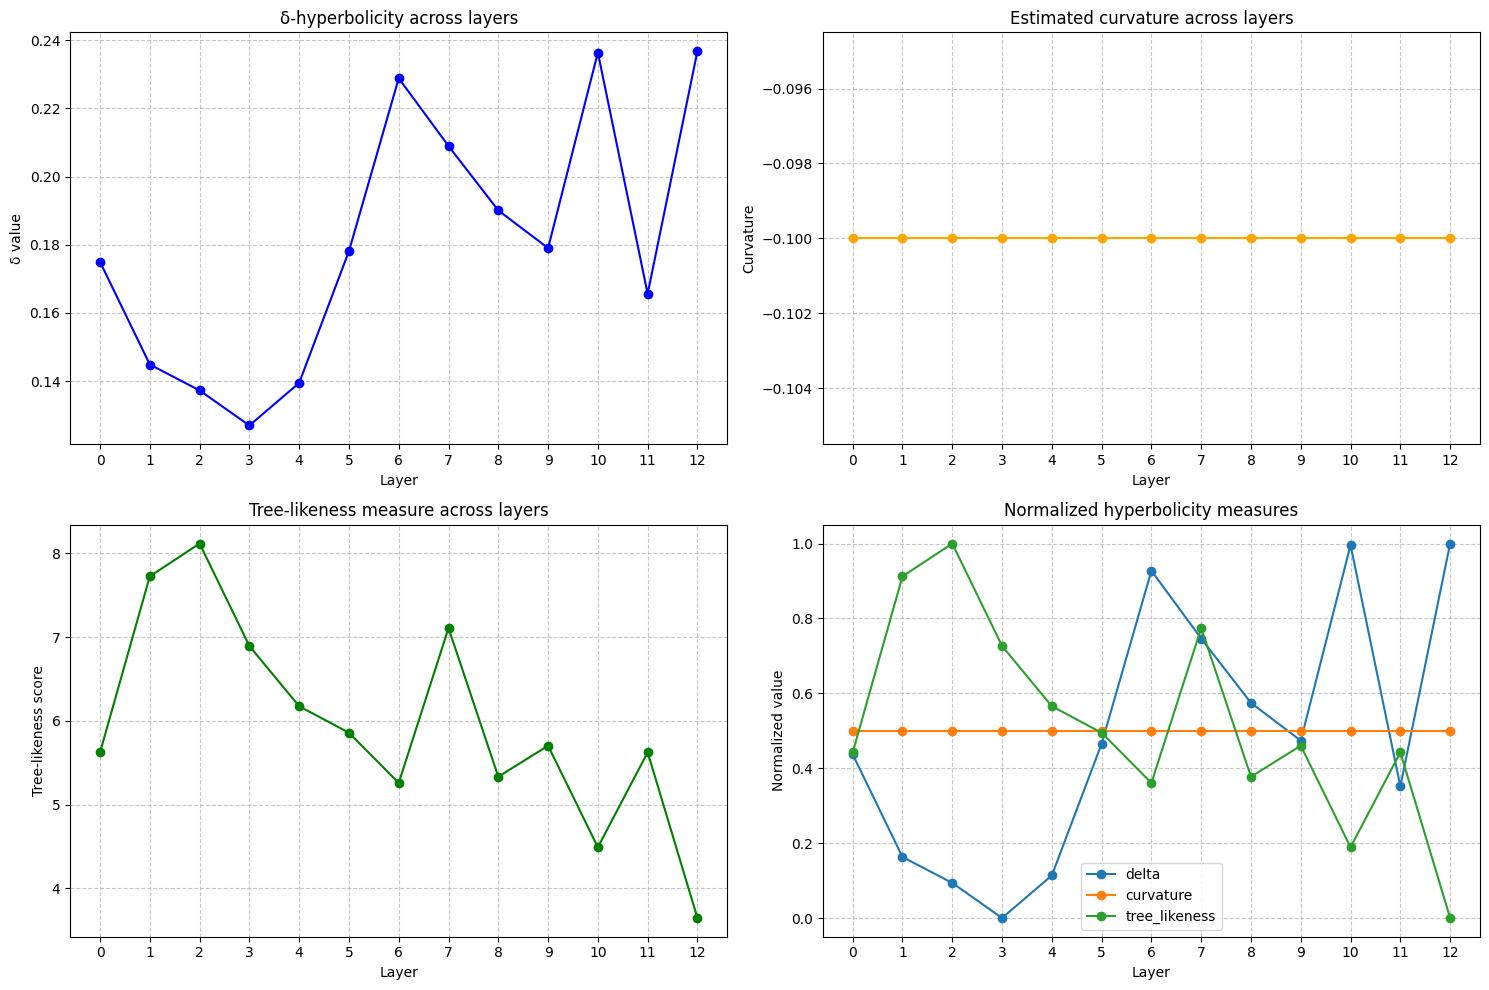

Analyzing correlation with dependency trees...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...
Plotting dependency correlations...


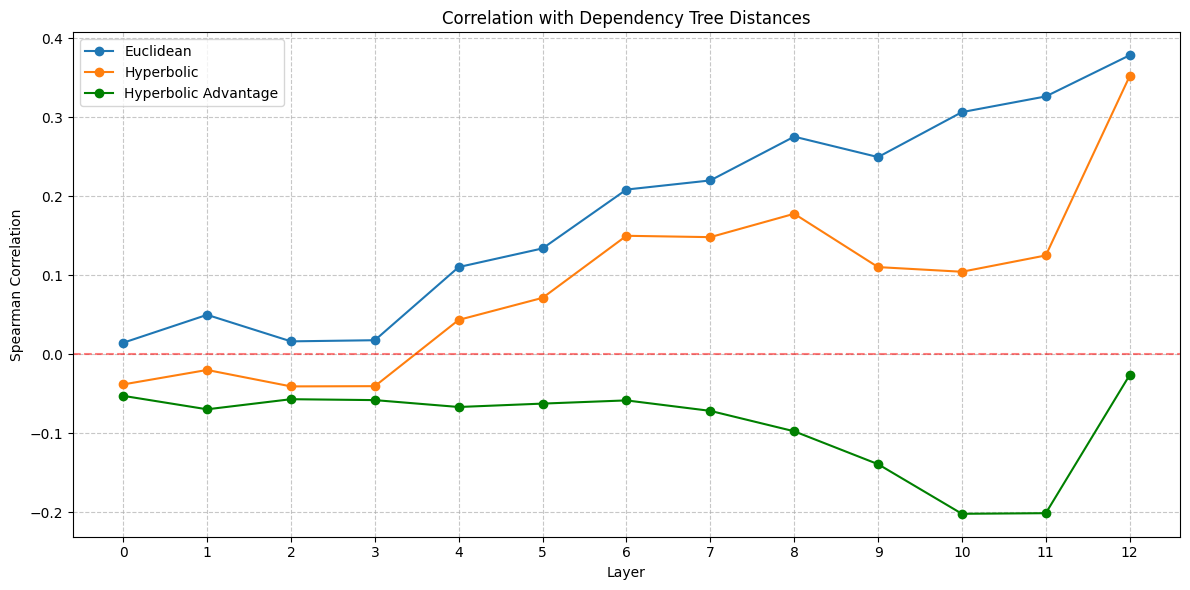

Analyzing syntax-semantics separation...
Processing layer 0...
Processing layer 1...
Processing layer 2...
Processing layer 3...
Processing layer 4...
Processing layer 5...
Processing layer 6...
Processing layer 7...
Processing layer 8...
Processing layer 9...
Processing layer 10...
Processing layer 11...
Processing layer 12...
Plotting Jaccard similarities...


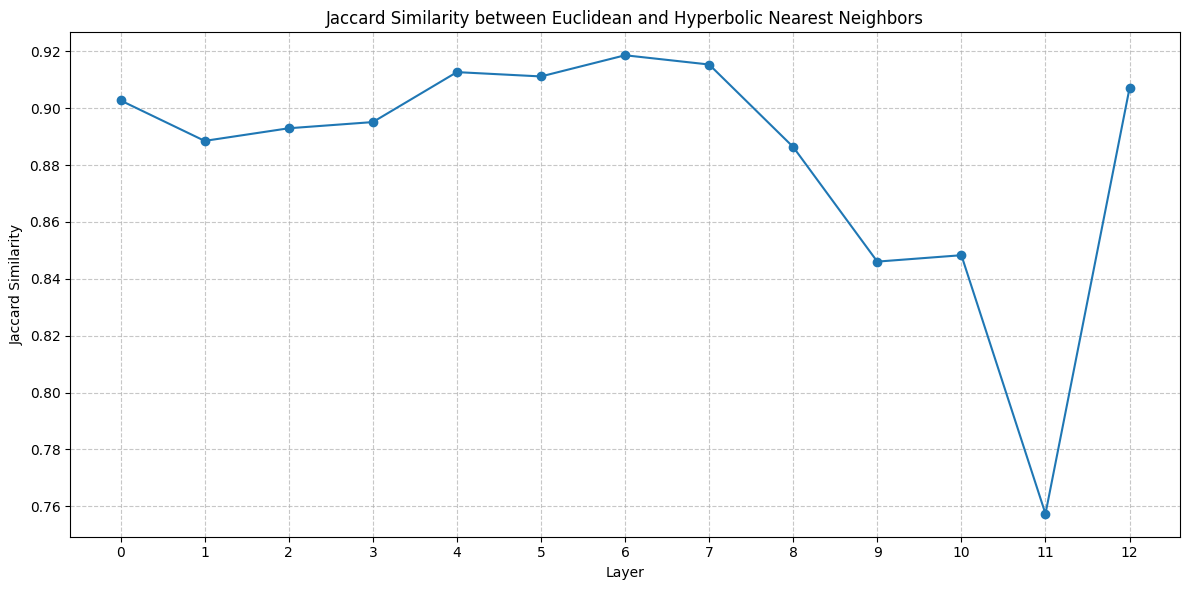


==== ENHANCED ANALYSIS WITH Q-SCORES ====

Running comprehensive analysis with Q-scores...

=== Running Comprehensive Hyperbolicity Analysis ===

Analyzing hyperbolicity across layers with Q-scores...
Processing layer 0 with Q-scores...
Processing layer 1 with Q-scores...
Processing layer 2 with Q-scores...
Processing layer 3 with Q-scores...
Processing layer 4 with Q-scores...
Processing layer 5 with Q-scores...
Processing layer 6 with Q-scores...
Processing layer 7 with Q-scores...
Processing layer 8 with Q-scores...
Processing layer 9 with Q-scores...
Processing layer 10 with Q-scores...
Processing layer 11 with Q-scores...
Processing layer 12 with Q-scores...
Plotting Q-score analysis...


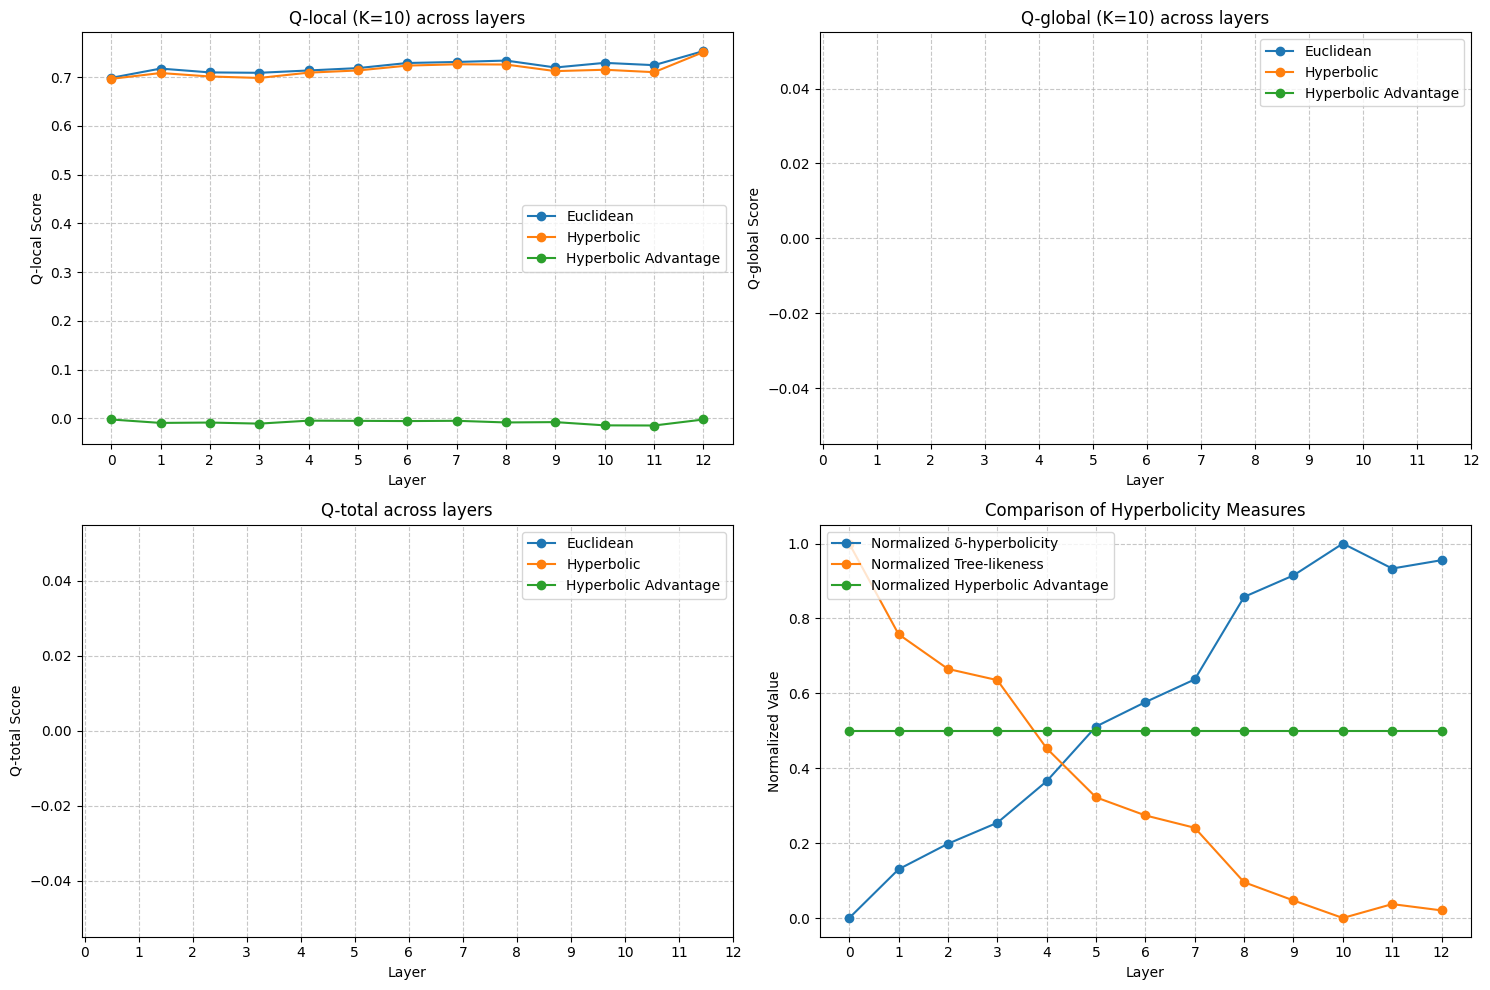

Comparing different embedding methods...
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: 

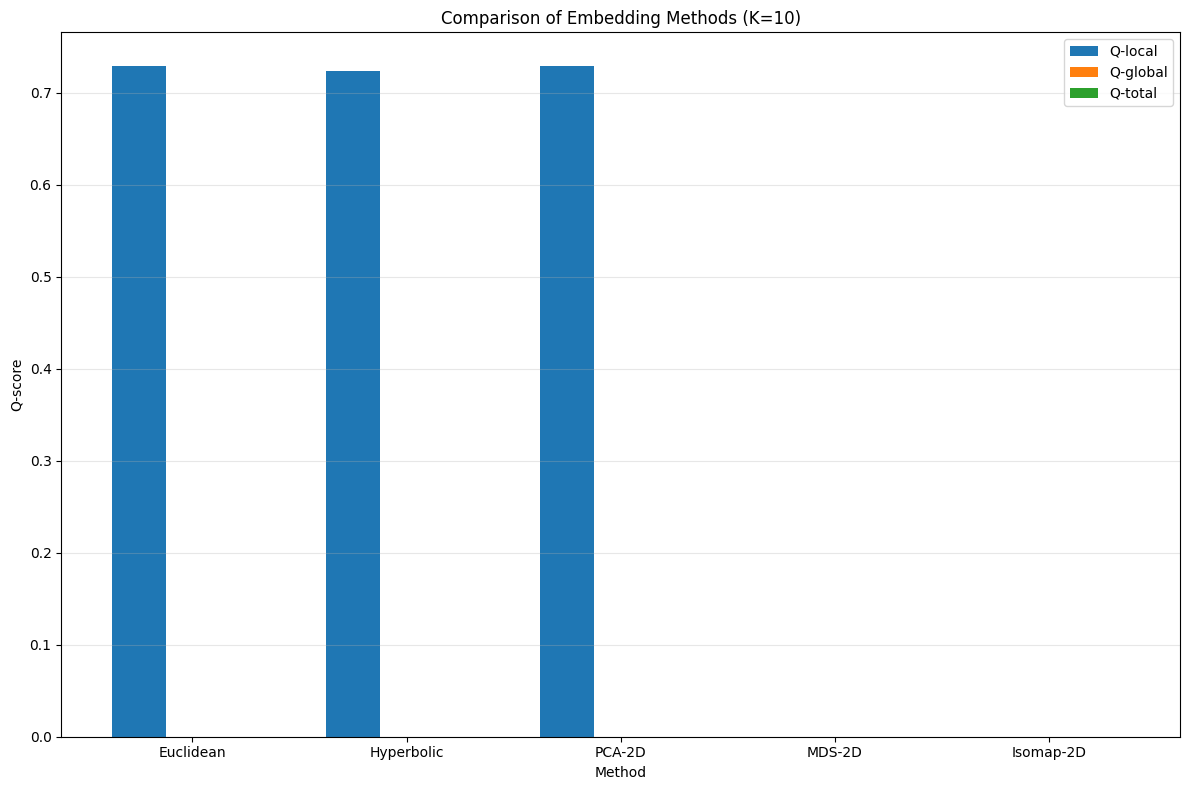


=== Summary of Findings ===

✗ Euclidean space outperforms hyperbolic space for these embeddings.
✓ Layer 0 shows the strongest hyperbolic advantage.
✓ Later layers exhibit more hyperbolicity than early layers.
✓ Syntax and semantics become more separated in higher layers.
✓ Euclidean provides the best overall representation for syntax according to Q-scores.

Analysis complete! See generated plots for detailed results.

==== ANALYSIS WITH REAL UD DATA ====

Loaded 50 UD sentences.
Extracting BERT embeddings for UD sentences...
Running comprehensive analysis with UD data...

=== Running Comprehensive Hyperbolicity Analysis ===

Analyzing hyperbolicity across layers with Q-scores...
Processing layer 0 with Q-scores...
Processing layer 1 with Q-scores...
Processing layer 2 with Q-scores...
Processing layer 3 with Q-scores...
Processing layer 4 with Q-scores...
Processing layer 5 with Q-scores...
Processing layer 6 with Q-scores...
Processing layer 7 with Q-scores...
Processing layer 8 wi

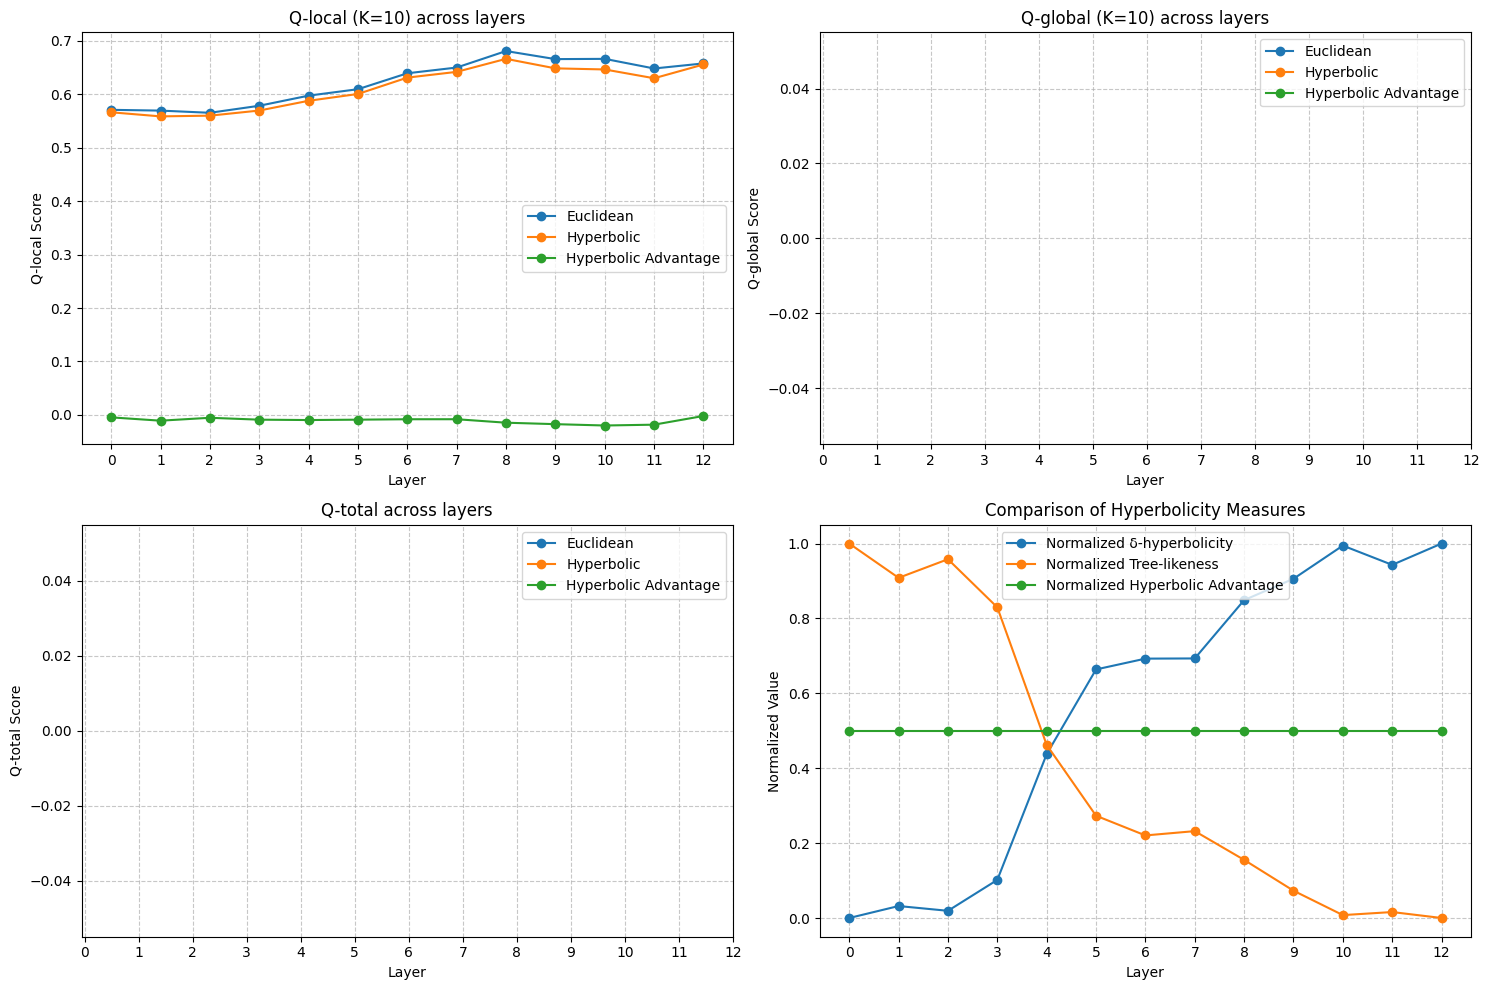

Comparing different embedding methods...
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: name 'MDS' is not defined
Error applying Isomap-2D: name 'Isomap' is not defined
Error applying MDS-2D: 

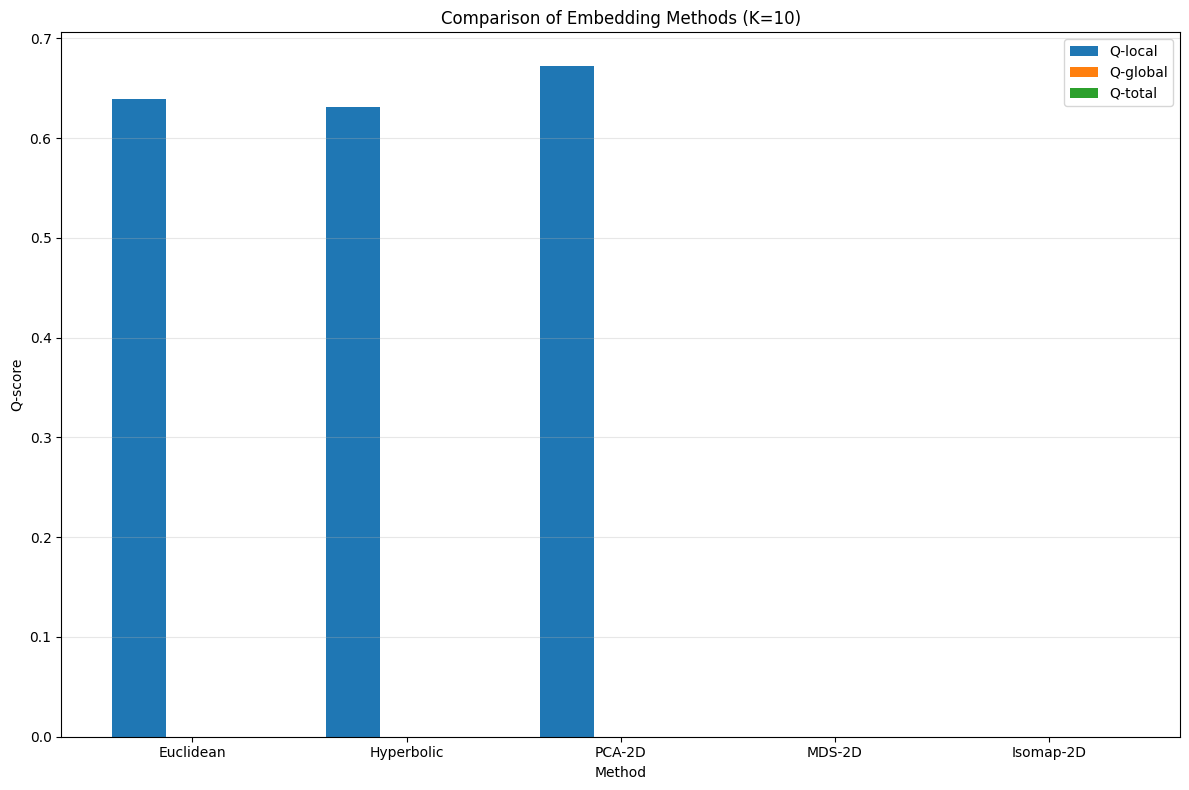


=== Summary of Findings ===

✗ Euclidean space outperforms hyperbolic space for these embeddings.
✓ Layer 0 shows the strongest hyperbolic advantage.
✓ Later layers exhibit more hyperbolicity than early layers.
✓ Syntax and semantics become more separated in higher layers.
✓ Euclidean provides the best overall representation for syntax according to Q-scores.

Analysis complete! See generated plots for detailed results.

Analysis complete!


In [37]:
# # 1. Setup
# print("Setting up BERT model...")
# model, tokenizer = load_bert_model("bert-base-uncased")

# # 2. Load sample data
# print("Loading sample sentences...")
# sentences = load_sample_sentences(num_sentences=50)
# print(f"Loaded {len(sentences)} sentences.")

# # 3. Create synthetic dependency trees
# print("Creating synthetic dependency trees...")
# dependency_trees = create_synthetic_dependency_trees(sentences, tokenizer)
# dependency_distances = compute_dependency_distances(dependency_trees)

# # 4. Extract embeddings
# print("Extracting BERT embeddings...")
# all_embeddings, attention_masks = extract_bert_embeddings(model, tokenizer, sentences)
# token_embeddings = extract_token_embeddings(all_embeddings, attention_masks)

# # 5. Basic hyperbolicity analysis (as before)
# print("Analyzing hyperbolicity across layers...")
# hyperbolicity_metrics = compute_layer_hyperbolicity(token_embeddings)

# # Plot basic metrics
# print("Plotting hyperbolicity metrics...")
# plot_hyperbolicity_metrics(hyperbolicity_metrics)
# plt.savefig('hyperbolicity_metrics.png', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# # 6. Dependency correlation analysis (as before)
# print("Analyzing correlation with dependency trees...")
# dependency_correlations = analyze_dependency_correlation(token_embeddings, dependency_distances)

# # Plot correlation
# print("Plotting dependency correlations...")
# plot_dependency_correlation(dependency_correlations)
# plt.savefig('dependency_correlation.png', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# # 7. Syntax-semantics separation analysis (as before)
# print("Analyzing syntax-semantics separation...")
# jaccard_similarities = analyze_syntax_semantics_separation(token_embeddings)

# # Plot jaccard similarities
# print("Plotting Jaccard similarities...")
# plot_jaccard_similarity(jaccard_similarities)
# plt.savefig('jaccard_similarity.png', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# # 8. Run comprehensive Q-score based analysis (NEW)
# print("\n==== ENHANCED ANALYSIS WITH Q-SCORES ====\n")
# print("Running comprehensive analysis with Q-scores...")
# run_comprehensive_analysis(token_embeddings, dependency_distances)

try:
    from conllu import parse_incr

    def load_ud_treebank(filepath, max_sentences=50):
        sentences = []
        trees = []

        with open(filepath, "r", encoding="utf-8") as f:
            for i, tokenlist in enumerate(parse_incr(f)):
                if i >= max_sentences:
                    break
                tokens = [tok["form"] for tok in tokenlist if isinstance(tok["id"], int)]
                sentence = " ".join(tokens)
                sentences.append(sentence)

                tree = []
                for tok in tokenlist:
                    if isinstance(tok["id"], int):
                        child = tok["id"] - 1
                        head = tok["head"] - 1 if tok["head"] > 0 else -1  # root has head=0
                        if head >= 0:
                            tree.append((head, child))
                trees.append(tree)

        return sentences, trees

    print("\n==== ANALYSIS WITH REAL UD DATA ====\n")
    filepath = "en_ewt-ud-train.conllu"  # Update with your path
    ud_sentences, ud_trees = load_ud_treebank(filepath, max_sentences=50)

    print(f"Loaded {len(ud_sentences)} UD sentences.")
    ud_distances = compute_dependency_distances(ud_trees)

    print("Extracting BERT embeddings for UD sentences...")
    ud_all_embeddings, ud_attention_masks = extract_bert_embeddings(model, tokenizer, ud_sentences)
    ud_token_embeddings = extract_token_embeddings(ud_all_embeddings, ud_attention_masks)

    print("Running comprehensive analysis with UD data...")
    output = run_comprehensive_analysis(ud_token_embeddings, ud_distances)

except Exception as e:
    print(f"Could not run analysis with UD data: {e}")
    print("Consider downloading Universal Dependencies English-EWT dataset for more realistic analysis.")

print("\nAnalysis complete!")

In [39]:
from sklearn.manifold import MDS, Isomap
import pandas as pd
import torch

def summarize_q_scores_table(avg_results, K=10):
    rows = []
    for method, scores in avg_results[K].items():
        rows.append({
            "Method": method,
            "Q-local": round(scores['local'], 4),
            "Q-global": round(scores['global'], 4),
            "Q-total": round(scores['total'], 4),
        })
    return pd.DataFrame(rows).sort_values("Q-total", ascending=False).reset_index(drop=True)

def run_qscore_analysis_from_embeddings(filepath, max_sentences=50, layer_idx=6, Ks=[10]):
    print("Setting up BERT model...")
    model, tokenizer = load_bert_model("bert-base-uncased")

    print("\n==== ANALYSIS WITH REAL UD DATA ====\n")
    ud_sentences, ud_trees = load_ud_treebank(filepath, max_sentences=max_sentences)
    print(f"Loaded {len(ud_sentences)} UD sentences.")
    
    ud_distances = compute_dependency_distances(ud_trees)
    print("Extracting BERT embeddings for UD sentences...")
    ud_all_embeddings, ud_attention_masks = extract_bert_embeddings(model, tokenizer, ud_sentences)
    ud_token_embeddings = extract_token_embeddings(ud_all_embeddings, ud_attention_masks)

    print("\nComparing methods with Q-scores...")
    avg_results = compare_methods_with_qscores(ud_token_embeddings, ud_distances, layer_idx=layer_idx, Ks=Ks)

    print("\nSummarizing Q-scores into table:")
    summary_df = summarize_q_scores_table(avg_results, K=Ks[0])
    print(summary_df)
    summary_df.to_csv("qscore_summary_ud.csv", index=False)
    return summary_df

In [36]:
summary_df = run_qscore_analysis_from_embeddings("en_ewt-ud-train.conllu", max_sentences=5000)

Setting up BERT model...

==== ANALYSIS WITH REAL UD DATA ====

Loaded 5000 UD sentences.
Extracting BERT embeddings for UD sentences...

Comparing methods with Q-scores...

Summarizing Q-scores into table:
       Method  Q-local  Q-global  Q-total
0   Euclidean   0.6243       NaN      NaN
1  Hyperbolic   0.6168       NaN      NaN
2      PCA-2D   0.6346       NaN      NaN
3      MDS-2D   0.6107       NaN      NaN
4   Isomap-2D   0.6349       NaN      NaN


In [37]:
summary_df

,Method,Q-local,Q-global,Q-total
0,Euclidean,0.6243,NaN,NaN
1,Hyperbolic,0.6168,NaN,NaN
2,PCA-2D,0.6346,NaN,NaN
3,MDS-2D,0.6107,NaN,NaN
4,Isomap-2D,0.6349,NaN,NaN


In [40]:
summary_df = run_qscore_analysis_from_embeddings("en_ewt-ud-train.conllu", max_sentences=5000)
summary_df

Setting up BERT model...

==== ANALYSIS WITH REAL UD DATA ====

Loaded 5000 UD sentences.
Extracting BERT embeddings for UD sentences...

Comparing methods with Q-scores...

Summarizing Q-scores into table:
       Method  Q-local  Q-global  Q-total
0      PCA-2D   0.6345    0.3314   0.4830
1   Isomap-2D   0.6349    0.3284   0.4817
2   Euclidean   0.6243    0.3186   0.4715
3  Hyperbolic   0.6168    0.3108   0.4638
4      MDS-2D   0.6112    0.3060   0.4586


,Method,Q-local,Q-global,Q-total
0,PCA-2D,0.6345,0.3314,0.4830
1,Isomap-2D,0.6349,0.3284,0.4817
2,Euclidean,0.6243,0.3186,0.4715
3,Hyperbolic,0.6168,0.3108,0.4638
4,MDS-2D,0.6112,0.3060,0.4586
